# Libraries

In [1]:
#%pip install tensorflow[and-cuda]
#%pip install ipywidgets
import tensorflow as tf
import random
import numpy as np
import numpy.random as rnd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
import itertools
from concurrent.futures import ProcessPoolExecutor
import csv
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from datetime import datetime
import pandas as pd
from keras.saving import register_keras_serializable
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, recall_score, precision_score
import glob
%matplotlib inline
#plt.ion() 

# Global constants

session_length = 300
number_of_hid_units = 3
kelvin=273.15
np.random.seed(49)
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)


2025-04-30 15:52:17.760309: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 15:52:17.767866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746028337.776280    5509 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746028337.778825    5509 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746028337.785353    5509 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# limit GPU memory access 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])

# Modeling

In [4]:
'''Class for environment simulation'''

class environment():

    '''environment initializer'''

    def __init__(self, init_s):

        '''init_s: tuple of initial parameters

           self.t: temperature of air
           self.vent_degree: vent. level
           self.t_h: temperature of heater
           self.t_out: temperature outside, this values is also used as an average temperature for the calculated period
           self.c: 1 t_out is constant,0 it is modeled'''

        '''original fuction'''

        'self.t, self.vent_degree, self.t_h, self.t_w, self.t_out = init_s'

        'my version'

        self.t, self.vent_degree, self.t_h, self.t_w, self.t_out, self.c = init_s
        self.t_avg=self.t_out-4


    '''one step of environment'''


    def step2(self, a,scalled_step_n):


      '''a: tuple of actions
        heat: state of heater
        vent: state of vent.'''


      if scalled_step_n >= np.pi:
        n=math.floor(scalled_step_n/np.pi)
        scalled_step_n-=n*np.pi

      '''update of env. parameters'''

      'my version'

      t_c_fluid=np.interp(self.t_out,[293.15,318.1],[293.15,278.15])
      #self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*(self.t_w - self.t) +0.016*a[2]*(t_c_fluid-self.t)
      self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*(self.t_w - self.t) +0.016*a[2]*(283.15-self.t)

      t_w_fluid=np.interp(self.t_out,[253.15,318.1],[340.15,298.15])

      self.t_h += (t_w_fluid- self.t_h)*( 0.08 * a[0])-0.05*(self.t_h -self.t)


      self.t_w += 0.1 * (self.t - self.t_w) + 0.1 * (self.t_out - self.t_w)


      #self.t_w = self.t_w + 0.05 * (self.t - self.t_w) - 0.1 * (self.t_out - self.t_w)
      if self.c==1:
       self.t_out = self.t_out
      else:
        self.t_out += 0.01*np.cos(scalled_step_n-0.7)+(self.t_avg-self.t_out)*0.001+0.01*np.random.randn()

      '''checking of boundaries'''

      if self.t_h<kelvin:
            self.t_h = kelvin
      elif self.t_h>323.15:
            self.t_h = 323.15

      self.vent_degree = self.vent_degree - (1 - a[1]) + 3*a[1]

      if self.vent_degree<0:
          self.vent_degree = 0
      elif self.vent_degree>60:
          self.vent_degree = 60

      '''returns visible parameters of environment'''


      return self.t, self.vent_degree, self.t_out



    def step3(self, a,scalled_step_n, fault, multiplier=None ):

      '''a: tuple of actions
      heat: state of heater
      vent: state of vent.'''


      if scalled_step_n >= np.pi:
        n=math.floor(scalled_step_n/np.pi)
        scalled_step_n-=n*np.pi


      '''update of env. parameters'''

      'my version'



      if fault:
        self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*multiplier*(self.t_w - self.t) +0.016*a[2]*(283.15-self.t)
      else:
        self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*(self.t_w - self.t) +0.016*a[2]*(283.15-self.t)

      t_w_fluid=np.interp(self.t_out,[253.15,318.1],[340.15,298.15])

      self.t_h += (t_w_fluid- self.t_h)*( 0.08 * a[0])-0.05*(self.t_h -self.t)


      self.t_w += 0.1 * (self.t - self.t_w) + 0.1 * (self.t_out - self.t_w)


      #self.t_w = self.t_w + 0.05 * (self.t - self.t_w) - 0.1 * (self.t_out - self.t_w)
      if self.c==1:
       self.t_out = self.t_out
      else:
        self.t_out += 0.01*np.cos(scalled_step_n-0.7)+(self.t_avg-self.t_out)*0.001+0.005*np.random.randn()

      '''checking of boundaries'''

      if self.t_h<kelvin:
            self.t_h = kelvin
      elif self.t_h>323.15:
            self.t_h = 323.15

      self.vent_degree = self.vent_degree - (1 - a[1]) + 3*a[1]

      if self.vent_degree<0:
          self.vent_degree = 0
      elif self.vent_degree>60:
          self.vent_degree = 60

      return self.t, self.vent_degree, self.t_out

    '''sample session with random control

       num_of_steps: number of time steps
       sigma: std deviation of additive noise
       '''

    '''sample session with random control

       num_of_steps: number of time steps
       sigma: std deviation of additive noise
       '''


    def controlled_session(self, num_of_steps, sigma,t_set,v_set,dt,dv):
      '''initializing sets of env. parameters'''
      collection_a = np.zeros((0,3), dtype=int)
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []

      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = np.zeros((1,3), dtype=int)
      HoC=False
      '''for hvac, so a[0][0] is the heating on/off comand, a[0][1] for ventilation and a[0][2] for ac'''
      OldRange = (1440 - 0)
      NewRange = (np.pi - 0)

      '''main loop'''


      for i in range(num_of_steps):
        if i%300==0:
          if self.t_out<t_set-dt:
            HoC=True
          else:
            HoC=False
        collection_t.append(t)
        collection_noisy_t.append(noisy_t)
        collection_t_out.append(t_out)
        if noisy_t >= t_set+dt and HoC:
          a[0,0]=0
        elif noisy_t >= t_set+dt and not HoC:
          a[0,2]=1
        elif noisy_t <= t_set-dt and HoC:
          a[0,0]=1
        elif noisy_t <= t_set-dt and not HoC:
          a[0,2]=0
        if self.vent_degree> v_set+dv:
          a[0,1]=0
        elif self.vent_degree< v_set-dv:
          a[0,1]=1
        else:
          a[0,1]=a[0,1]


        collection_a=np.append(collection_a,a, axis=0)
        scaled_step = (((i - 0) * NewRange) / OldRange) + 0
        t, vent, t_out = self.step2(a[0],scaled_step)
        noisy_t = t + sigma*np.random.randn()

      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''

      return np.array(collection_t), np.array(collection_noisy_t), collection_a, np.array(collection_t_out)

    def DR_session(self, num_of_steps, sigma,t_set,v_set,dt,dv, DR_start, confort_boundary):
      '''initializing sets of env. parameters'''
      collection_a = np.zeros((0,3), dtype=int)
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []
      collection_DR=[]
      index=0
      check= False

      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = np.zeros((1,3), dtype=int)

      '''for hvac, so a[0][0] is the heating on/off comand, a[0][1] for ventilation and a[0][2] for ac'''
      OldRange = (1440 - 0)
      NewRange = (np.pi - 0)
      if self.t_out<t_set-dt:
        HoC=True
        boundary=t_set-confort_boundary
      else:
        HoC=False
        boundary=t_set+confort_boundary

      '''main loop'''

      for i in range(num_of_steps):
        if i==DR_start:
          check=True

        if check==False:
          collection_DR.append(0)
          if noisy_t >= t_set+dt and HoC:
            a[0,0]=0
          elif noisy_t >= t_set+dt and not HoC:
            a[0,2]=1
          elif noisy_t <= t_set-dt and HoC:
            a[0,0]=1
          elif noisy_t <= t_set-dt and not HoC:
            a[0,2]=0
          if self.vent_degree> v_set+dv:
            a[0,1]=0
          elif self.vent_degree< v_set-dv:
            a[0,1]=1
          else:
            a[0,1]=a[0,1]
        else:
          collection_DR.append(i-DR_start+1)
          if self.vent_degree> v_set+dv:
            a[0]=[0,0,0]
          elif self.vent_degree< v_set-dv:
            a[0]=[0,1,0]
          else:
            b=a[0,1]
            a[0]=[0,0,0]
            a[0,1]=b
        collection_t.append(t)
        collection_noisy_t.append(noisy_t)
        collection_t_out.append(t_out)
        collection_a=np.append(collection_a,a, axis=0)
        scaled_step = (((i - 0) * NewRange) / OldRange) + 0
        t, vent, t_out = self.step2(a[0],scaled_step)
        noisy_t = t + sigma*np.random.randn()

        if abs(round(t,1)- round(boundary,1))<=0.25 and check== True:
          index=i
          #check= False



      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''

      return np.array(collection_t), np.array(collection_noisy_t), collection_a, np.array(collection_t_out), np.array(collection_DR), index,boundary


    def faulty_session(self, num_of_steps, sigma,t_set,v_set,dt,dv, fault_type,fault_start,increased_factor=None):
      """

      Args:
        num_of_steps:data generation window size, 1 step=1 minute
        sigma: std of the generated Gaussian noise
        t_set: goal temperature for the control system
        v_set:goal ventilation level for the control system
        dt: tolatence range for the goal temperature +-dt
        dv:tolatence range for the goal ventilation +-dt
        fault_type: select one of the possible faults to be modelled
                    0: at fault_start time the Heating becomes unresponsive and turns off,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    1:at fault_start time the Heating becomes unresponsive and turns on,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    2: at fault_start time the cooling becomes unresponsive and turns off,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    3:at fault_start time the cooling becomes unresponsive and turns on,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    4:at fault_start time the insolation becomes 1.5 times worse or the given increased_factor times worse (do last)
                    5:at fault_start time the sensor data becomes 1.5 times worse or the given increased_factor times worse

        fault_start: moment in time when the normal data becomes faulty data,
        set to 0 for faults that start before the generated data t0 or earlier,
        feed a random number between 150 and 300 to simulate the fault ocurring at any random time.
        increased_factor:None or float, the factor of how many times the insulation or noise level of the generated data would become worse
      """
      '''initializing history of of env. parameters'''
      collection_a = np.zeros((0,3), dtype=int)
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []
      '''initializing  history of env. parameters for fault simulation'''
      collection_a_f = np.zeros((0,3), dtype=int) #for cases 0-3
      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = np.zeros((1,3), dtype=int)
      HoC=False
      OldRange = (1440 - 0)
      NewRange = (np.pi - 0)

      if self.t_out<t_set-dt:
        HoC=True

      else:
        HoC=False


      '''initial values of env. parameters for fault simulation'''
      a_f = np.copy(a)
      if increased_factor== None:
        multiplier=1.5
      else:
        multiplier=increased_factor
      '''main loop'''
      for i in range(num_of_steps):
        collection_t.append(t)
        collection_noisy_t.append(noisy_t)
        collection_t_out.append(t_out)
        if noisy_t >= t_set+dt and HoC:
          a[0,0]=0
        elif noisy_t >= t_set+dt and not HoC:
          a[0,2]=1
        elif noisy_t <= t_set-dt and HoC:
          a[0,0]=1
        elif noisy_t <= t_set-dt and not HoC:
          a[0,2]=0
        if self.vent_degree> v_set+dv:
          a[0,1]=0
        elif self.vent_degree< v_set-dv:
          a[0,1]=1
        else:
          a[0,1]=a[0,1]
        if fault_type==0:
          a_f = np.copy(a)
          a_f[0,0]=0
        elif fault_type==1:
          a_f = np.copy(a)
          a_f[0,0]=1
        elif fault_type==2:
          a_f = np.copy(a)
          a_f[0,2]=0
        elif fault_type==3:
          a_f = np.copy(a)
          a_f[0,2]=1
        collection_a=np.append(collection_a,a, axis=0)
        if (fault_type in [0,1,2,3] )and i>=fault_start:
          collection_a_f=np.append(collection_a_f,a_f, axis=0)
          a_for_agent = a_f[0]
        else:
          collection_a_f=np.append(collection_a_f,a, axis=0)
          a_for_agent = a[0]
        scaled_step = (((i - 0) * NewRange) / OldRange) + 0
        if fault_type==4  and i>=fault_start:
          t, _, t_out = self.step3(a_for_agent,scaled_step,multiplier=multiplier, fault= True)
        else:
          t, _, t_out = self.step3(a_for_agent,scaled_step,fault= False)
        if fault_type==5 and i>=fault_start:
          noisy_t = t + multiplier*sigma*np.random.randn()
        else:
          noisy_t = t + sigma*np.random.randn()

      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''

      return np.array(collection_t), np.array(collection_noisy_t), collection_a, np.array(collection_t_out),collection_a_f,HoC

def to_bin(x):
  y = (x*2**np.arange(x.shape[0]-1,-1,-1,dtype='int64')).sum()
  y = x.dot(1 << np.arange(x.size,dtype='int64')[::-1])
  return y

# Data generation

## Controlled data

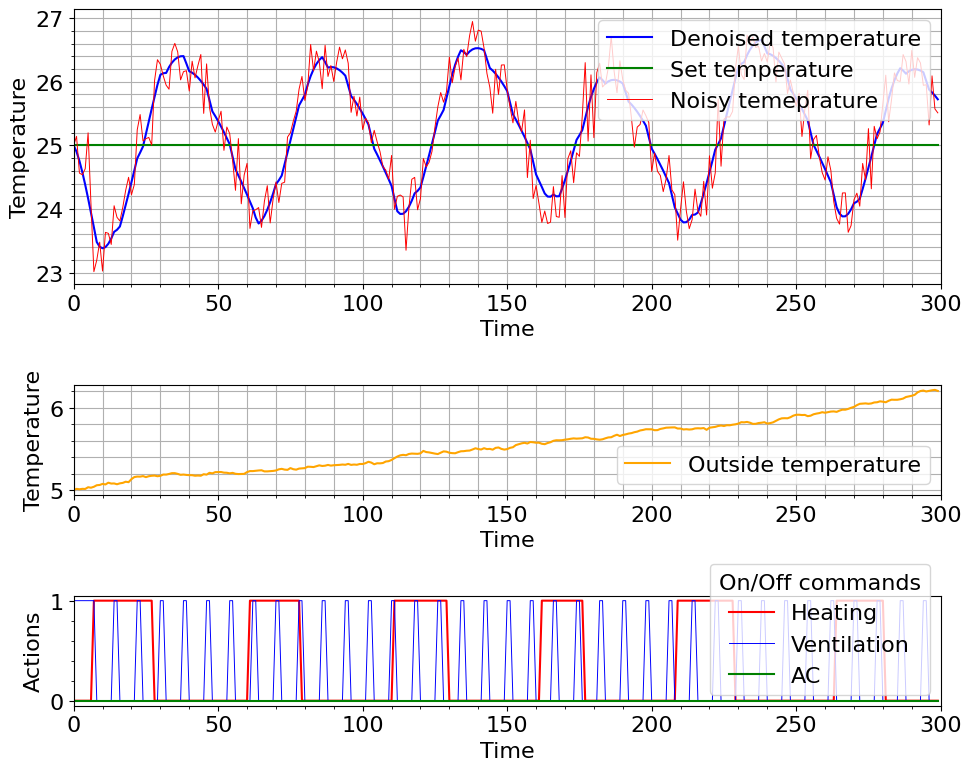

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/BML figures/simulation_example6.pdf'

In [185]:
'''generation of training set with target setpoints and constant t_out'''

"test for predictable behaviour"

#init_params_c = (298.15, 20, 298.15, 298.15, 298.15,1) #the room is termalised already
#init_params_c = (298.15, 20, 298.15, 298.15, 298.15,0) #the aerage temperature is the room initial temperature
#init_params_c = (298.15, 20, 298.15, 298.15, 293.15,0)# below by 5c from the set ponit
#init_params_c = (298.15, 20, 298.15, 298.15, 303.15,0)# up by 5c from the set ponit
#init_params_c = (298.15, 20, 298.15, 298.15, 240.15,1)# outside temperature low
init_params_c = (298.15, 20, 298.15, 298.15, 278.15,0)# outside temperature too low

'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 1


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 8
session_length = 300
std_of_noise = 0.3

#init_params_c = (298.15, 20, 298.15, 298.15, 313.15,0) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
env_c = environment(init_params_c)
s_length = number_of_pieces * session_length
t_c, noisy_t_c, a_c, t_out_c = env_c.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)

'''reshaping dataset in appropriate for learning form'''
t_out_c = t_out_c.reshape((number_of_pieces, session_length))
t_out_c=t_out_c-kelvin
t_c = t_c.reshape((number_of_pieces, session_length))
t_c=t_c-kelvin
noisy_t_c = noisy_t_c.reshape((number_of_pieces, session_length))
noisy_t_c=noisy_t_c-kelvin
a_c_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_c)):
  y=to_bin(a_c[i])
  a_c_dec=np.append(a_c_dec,np.array([y]).reshape((1,1)), axis=0)
a_c_dec = a_c_dec.reshape((number_of_pieces, session_length))
heat_c =a_c[:,0].reshape((number_of_pieces, session_length))
vent_c = a_c[:,1].reshape((number_of_pieces, session_length))
ac_c=a_c[:,2].reshape((number_of_pieces, session_length))
t_set=t_set-kelvin

'''plotting of example'''
'''plotting of example'''
n0=0
fig, axs = plt.subplots(3, 1,gridspec_kw={'height_ratios': [2.5, 1,1]})
fig.set_figwidth(10)
fig.set_figheight(8)
axs[0].plot(t_c[n0], 'b',label="Denoised temperature")
#axs[0].plot(t_out_c[n0], 'orange',label="Outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="Set temperature")
axs[0].plot(noisy_t_c[n0], 'r',label="Noisy temeprature",linewidth=.7)
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend(loc=1)
axs[1].plot(t_out_c[n0], 'orange',label="Outside temperature")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Temperature')
axs[1].grid(True)
axs[1].grid(which = "minor")
axs[1].minorticks_on()
axs[1].legend(loc=4)
axs[2].plot(heat_c[n0], 'r',label="Heating")
axs[2].plot(vent_c[n0], 'b',label="Ventilation",linewidth=.7)
axs[2].plot(ac_c[n0], 'g',label="AC")
axs[2].set_xlim(0, 300)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Actions')
axs[2].grid(True)
axs[2].legend(loc=0, title='On/Off commands')
axs[2].grid(which = "major")
axs[2].minorticks_on()
fig.tight_layout()
plt.show()
test_n=6
fig.savefig('/content/drive/MyDrive/Colab Notebooks/BML figures/simulation_example'+str(test_n)+'.pdf', format='pdf')

## DR simulation

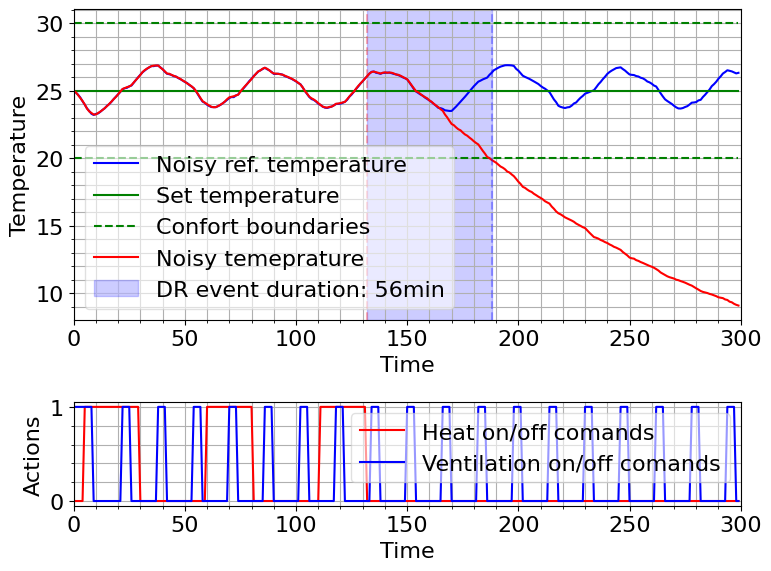

In [ ]:
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5
DR_start=132
boundary=5
'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
std_of_noise = 0.015

init_params_dr = (298.15, 20, 298.15, 298.15, 273.15,0) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
env_dr = environment(init_params_dr)
env_ref = environment(init_params_dr)
s_length = number_of_pieces * session_length

t_dr, noisy_t_dr, a_dr, t_out_dr,dr,index,conf_lim= env_dr.DR_session(s_length, std_of_noise,t_set,v_set,dt,dv,DR_start,boundary)
t_ref,noisy_t_ref,_,_=env_ref.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)

'''reshaping dataset in appropriate for learning form'''
t_out_dr = t_out_dr.reshape((number_of_pieces, session_length))
t_out_dr=t_out_dr-kelvin
t_dr = t_dr.reshape((number_of_pieces, session_length))
t_dr=t_dr-kelvin
noisy_t_dr = noisy_t_dr.reshape((number_of_pieces, session_length))
noisy_t_dr=noisy_t_dr-kelvin
a_dr_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_dr)):
  y=to_bin(a_dr[i])
  a_dr_dec=np.append(a_dr_dec,np.array([y]).reshape((1,1)), axis=0)
a_dr_dec = a_dr_dec.reshape((number_of_pieces, session_length))
heat_dr =a_dr[:,0].reshape((number_of_pieces, session_length))
vent_dr = a_dr[:,1].reshape((number_of_pieces, session_length))
ac_dr=a_dr[:,2].reshape((number_of_pieces, session_length))
t_set=t_set-kelvin

noisy_t_ref = noisy_t_ref.reshape((number_of_pieces, session_length))
noisy_t_ref=noisy_t_ref-kelvin
conf_lim= conf_lim- kelvin
'''plotting of example'''
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [3, 1]})
fig.set_figwidth(8)
fig.set_figheight(6)
#axs[0].plot(t_dr[0], 'y',label="denoised DR temperature")
axs[0].plot(noisy_t_ref[0], 'b',label="Noisy ref. temperature")
#axs[0].plot(t_out_dr[0], 'orange',label="outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="Set temperature")
axs[0].plot((t_set-boundary)*np.ones(300), 'g',label="Confort boundaries",linestyle='dashed')
axs[0].plot((t_set+boundary)*np.ones(300), 'g',linestyle='dashed')
axs[0].plot(noisy_t_dr[0], 'r',label="Noisy temeprature")
axs[0].axvspan(DR_start,index,color = 'b', label = 'DR event duration: '+str(index-DR_start)+'min',alpha=0.2)
axs[0].axvline(x = DR_start, color = 'r',linestyle='dashed',alpha=0.3)
axs[0].axvline(x = index, color = 'b',linestyle='dashed',alpha=0.3)
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend(framealpha=0.6,loc= 'lower left')
axs[1].plot(heat_dr[0], 'r',label="Heat on/off comands")
axs[1].plot(vent_dr[0], 'b',label="Ventilation on/off comands")
#axs[1].plot(ac_dr[0], 'g',label="ac on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Actions')
axs[1].grid(True)
axs[1].legend(framealpha=0.6)
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()
plt.show()


In [ ]:

fig.savefig('/content/drive/MyDrive/Colab Notebooks/BML figures/DR_planning_ max_duration.pdf', format='pdf')

## Fault data

1


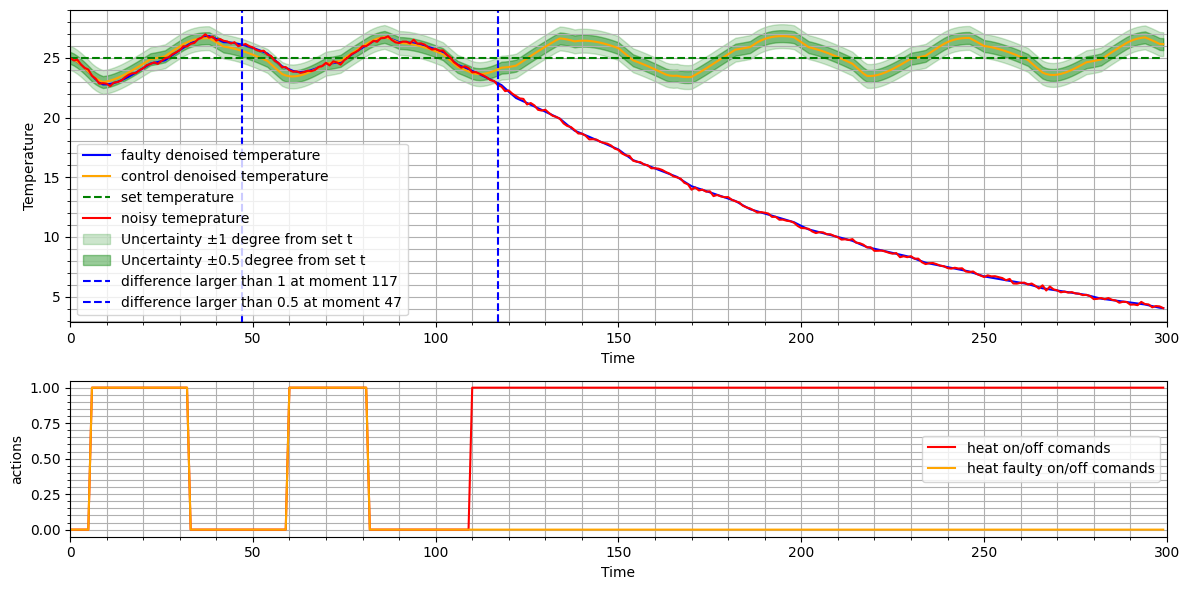

In [ ]:
"""fault_type: select one of the possible faults to be modelled
                     0: at fault_start time the Heating becomes unresponsive and turns off,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    1:at fault_start time the Heating becomes unresponsive and turns on,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    2: at fault_start time the cooling becomes unresponsive and turns off,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    3:at fault_start time the cooling becomes unresponsive and turns on,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    4:at fault_start time the insolation becomes 1.5 times worse or the given increased_factor times worse (do last)
                    5:at fault_start time the sensor data becomes 1.5 times worse or the given increased_factor times worse

         fault_start: moment in time when the normal data becomes faulty data,
          set to 0 for faults that start before the generated data t0 or earlier,
          feed a random number between 150 and 300 to simulate the fault ocurring at any random time.
          increased_factor:None or float, the factor of how many times the insulation or noise level of the generated data would become worse
"""

'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
std_of_noise = 0.1

init_params_f = (298.15, 20, 298.15, 298.15, 273.15,0) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
env_f = environment(init_params_f)
s_length = number_of_pieces * session_length
t_f, noisy_t_f, a_f, t_out_f,a_fault,_= env_f.faulty_session(s_length, std_of_noise,t_set,v_set,dt,dv, fault_type=0, fault_start=100,increased_factor=2.5)
env_c = environment(init_params_f)
t_c, noisy_t_c, a_c, t_out_c = env_c.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)
'''reshaping dataset in appropriate for learning form'''
t_out_f = t_out_f.reshape((number_of_pieces, session_length))
t_out_f=t_out_f-kelvin
t_f = t_f.reshape((number_of_pieces, session_length))
t_f=t_f-kelvin
t_c = t_c.reshape((number_of_pieces, session_length))
t_c=t_c-kelvin
noisy_t_f = noisy_t_f.reshape((number_of_pieces, session_length))
noisy_t_f=noisy_t_f-kelvin
t_set=t_set-kelvin


a_f_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_f)):
  y=to_bin(a_f[i])
  a_f_dec=np.append(a_f_dec,np.array([y]).reshape((1,1)), axis=0)
a_f_dec = a_f_dec.reshape((number_of_pieces, session_length))
heat_f =a_f[:,0].reshape((number_of_pieces, session_length))
vent_f = a_f[:,1].reshape((number_of_pieces, session_length))
ac_f=a_f[:,2].reshape((number_of_pieces, session_length))


a_fault_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_fault)):
  y=to_bin(a_fault[i])
  a_fault_dec=np.append(a_fault_dec,np.array([y]).reshape((1,1)), axis=0)
a_fault_dec = a_fault_dec.reshape((number_of_pieces, session_length))
heat_fault =a_fault[:,0].reshape((number_of_pieces, session_length))
vent_fault = a_fault[:,1].reshape((number_of_pieces, session_length))
ac_fault=a_fault[:,2].reshape((number_of_pieces, session_length))


'''plotting of example'''
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(12)
fig.set_figheight(6)
axs[0].plot(t_f[0], 'b',label="faulty denoised temperature")
axs[0].plot(t_c[0], 'orange',label="control denoised temperature")
#axs[0].plot(t_out_f[0], 'black',label="outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="set temperature",linestyle='dashed')
axs[0].plot(noisy_t_f[0], 'r',label="noisy temeprature")
axs[0].fill_between(range(300), t_c[0] - 1, t_c[0] + 1, color='green', alpha=0.2, label='Uncertainty ±1 degree from set t')
axs[0].fill_between(range(300), t_c[0] - 0.5, t_c[0] + 0.5, color='green', alpha=0.4, label='Uncertainty ±0.5 degree from set t')

limit_1 = None
limit_2 = None
outside_1 = (t_f[0] < t_c[0] - 1) | (t_f[0] > t_c[0] + 1)
outside_2 = (t_f[0] < t_c[0] - 0.5) | (t_f[0] > t_c[0] + 0.5)
for i in range(300):
    if outside_1[i] and limit_1 is None:
        limit_1 = i
if limit_1 is not None:
    axs[0].axvline(x = limit_1, color = 'b', label = 'difference larger than 1 at moment '+str(limit_1),linestyle='dashed')
for i in range(300):
    if outside_2[i] and limit_2 is None:
        limit_2 = i
if limit_2 is not None:
    axs[0].axvline(x = limit_2, color = 'b', label = 'difference larger than 0.5 at moment '+str(limit_2),linestyle='dashed')
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend()
axs[1].plot(heat_f[0], 'r',label="heat on/off comands")
#axs[1].plot(vent_f[0], 'b',label="ventilation on/off comands")
axs[1].plot(heat_fault[0], 'orange',label="heat faulty on/off comands")
#axs[1].plot(vent_fault[0], 'green',label="ventilation faulty on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()
plt.show()


In [ ]:
_

True

## training bach data generation

In [182]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 8
session_length = 300
s_length = number_of_pieces * session_length

std_of_noise =np.round(np.linspace(0.01,0.5,5),decimals=2)
t_start=np.round(np.linspace(293.15,303.15,5),decimals=2)
v_start= np.round(np.linspace(20,60,4),decimals=2)
t_h_start= np.round(np.linspace(293.15,340.15,5),decimals=2)
t_w_start= np.round(np.linspace(273.15,308.15,10),decimals=2)
t_out_start= np.round(np.linspace(253.15,295.15,15),decimals=2)
init_params_c = list(itertools.product(t_start, v_start, t_h_start, t_w_start, t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#init_params_c_tset = list(itertools.product(t_start, v_start, t_h_start, t_w_start, [t_set],[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#inint_test=init_params_c+init_params_c_tset+init_params_c_tset+init_params_c_tset+init_params_c_tset
init_params_c_sh= random.sample(init_params_c, len(init_params_c))
np.random.shuffle(std_of_noise)

In [184]:
t_start

array([293.15, 295.65, 298.15, 300.65, 303.15])

In [ ]:
len(init_params_c_sh)

15000

In [ ]:
t_out_c = np.empty([number_of_pieces, session_length])
t_c=np.empty([number_of_pieces, session_length])
noisy_t_c=np.empty([number_of_pieces, session_length])
a_c=np.empty([number_of_pieces, session_length])




for i in tqdm(range(0,500)):
  env_c = environment(init_params_c_sh[i])
  for j in range(len(std_of_noise)):
    t_ci, noisy_t_ci, a_ci, t_out_ci = env_c.controlled_session(s_length, std_of_noise[j],t_set,v_set,dt,dv)

    '''reshaping dataset in appropriate for learning form'''
    t_out_ci = t_out_ci.reshape((number_of_pieces, session_length))
    t_out_ci=t_out_ci[1]-kelvin
    t_ci = t_ci.reshape((number_of_pieces, session_length))
    t_ci=t_ci[1]-kelvin
    noisy_t_ci = noisy_t_ci.reshape((number_of_pieces, session_length))
    noisy_t_ci=noisy_t_ci[1]-kelvin
    a_c_dec= np.zeros((0,1), dtype=int)
    for i in range(len(a_ci)):
      y=to_bin(a_ci[i])
      a_c_dec=np.append(a_c_dec,np.array([y]).reshape(1,1), axis=0)
    a_c_dec = a_c_dec.reshape((number_of_pieces, session_length))
    a_c_dec = a_c_dec[1]
    #heat_c,vent_c = np.unravel_index(a_c, (2, 2))


    #concatenate

    t_out_c=np.vstack((t_out_c,t_out_ci))
    t_c=np.vstack((t_c,t_ci))
    noisy_t_c=np.vstack((noisy_t_c,noisy_t_ci))
    a_c=np.vstack((a_c,a_c_dec))
t_out_c=t_out_c[number_of_pieces:,:]
t_c=t_c[number_of_pieces:,:]
noisy_t_c=noisy_t_c[number_of_pieces:,:]
a_c=a_c[number_of_pieces:,:]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_heatingonly.npz', t_out_c=t_out_c, t_c=t_c,noisy_t_c=noisy_t_c,a_c=a_c)

## tests batch dataset


In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 2
session_length = 300
s_length = number_of_pieces * session_length

std_of_noise =[0.8]
t_start=np.round(np.linspace(293.15,303.15,8),decimals=2)
v_start= np.round(np.linspace(20,60,10),decimals=2)
t_h_start= np.round(np.linspace(293.15,340.15,8),decimals=2)
t_w_start= np.round(np.linspace(273.15,308.15,14),decimals=2)
t_out_start= np.round(np.linspace(253.15,290.15,8),decimals=2)
init_params_c = list(itertools.product(t_start, v_start, t_h_start, t_w_start, t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
init_params_c_tset = list(itertools.product(t_start, v_start, t_h_start, t_w_start, [t_set],[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#inint_test=init_params_c+init_params_c_tset+init_params_c_tset+init_params_c_tset+init_params_c_tset
init_params_c_sh= random.sample(init_params_c, len(init_params_c))
#np.random.shuffle(std_of_noise)

In [ ]:
std_of_noise

[0.8]

In [ ]:
t_out_c = np.empty([number_of_pieces, session_length])
t_c=np.empty([number_of_pieces, session_length])
noisy_t_c=np.empty([number_of_pieces, session_length])
a_c=np.empty([number_of_pieces, session_length])




for i in tqdm(range(0,500)):
  env_c = environment(init_params_c_sh[i])
  for j in range(len(std_of_noise)):
    t_ci, noisy_t_ci, a_ci, t_out_ci = env_c.controlled_session(s_length, std_of_noise[j],t_set,v_set,dt,dv)

    '''reshaping dataset in appropriate for learning form'''
    t_out_ci = t_out_ci.reshape((number_of_pieces, session_length))
    t_out_ci=t_out_ci[1]-kelvin
    t_ci = t_ci.reshape((number_of_pieces, session_length))
    t_ci=t_ci[1]-kelvin
    noisy_t_ci = noisy_t_ci.reshape((number_of_pieces, session_length))
    noisy_t_ci=noisy_t_ci[1]-kelvin
    a_c_dec= np.zeros((0,1), dtype=int)
    for i in range(len(a_ci)):
      y=to_bin(a_ci[i])
      a_c_dec=np.append(a_c_dec,np.array([y]).reshape(1,1), axis=0)
    a_c_dec = a_c_dec.reshape((number_of_pieces, session_length))
    a_c_dec = a_c_dec[1]
    #heat_c,vent_c = np.unravel_index(a_c, (2, 2))


    #concatenate

    t_out_c=np.vstack((t_out_c,t_out_ci))
    t_c=np.vstack((t_c,t_ci))
    noisy_t_c=np.vstack((noisy_t_c,noisy_t_ci))
    a_c=np.vstack((a_c,a_c_dec))
t_out_c=t_out_c[number_of_pieces:,:]
t_c=t_c[number_of_pieces:,:]
noisy_t_c=noisy_t_c[number_of_pieces:,:]
a_c=a_c[number_of_pieces:,:]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_noise_effect_test.npz', t_out_c=t_out_c[number_of_pieces:], t_c=t_c[number_of_pieces:],noisy_t_c=noisy_t_c[number_of_pieces:],a_c=a_c[number_of_pieces:])

## DR test batch dataset

In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5

'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
s_length = number_of_pieces * session_length
std_of_noise =0.1
t_start=298.15
v_start= 40
t_h_start= 298.15
t_w_start= 298.15
#t_out_start=np.round(np.linspace(258.15,291.15,5),decimals=1)
t_out_start= np.round(np.linspace(302.15,310.15,5),decimals=1)
#t_out_start= np.concatenate((np.round(np.linspace(258.15,291.15,5),decimals=1), np.round(np.linspace(302.15,310.15,5),decimals=1)), axis=None)
init_params_c = list(itertools.product([t_start], [v_start], [t_h_start], [t_w_start], t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
init_params_c= random.sample(init_params_c, len(init_params_c))
DR_start=np.round(np.linspace(190,220,20),decimals=0)
np.random.shuffle(DR_start)
boundary=[4,4.5,5,5.5,6]

In [ ]:
init_params_c

[(298.15, 40, 298.15, 298.15, 302.2, 0),
 (298.15, 40, 298.15, 298.15, 310.2, 0),
 (298.15, 40, 298.15, 298.15, 308.2, 0),
 (298.15, 40, 298.15, 298.15, 304.2, 0),
 (298.15, 40, 298.15, 298.15, 306.2, 0)]

In [ ]:
t_out_dr = np.empty([number_of_pieces, session_length])
t_dr=np.empty([number_of_pieces, session_length])
noisy_t_dr=np.empty([number_of_pieces, session_length])
a_dr=np.empty([number_of_pieces, session_length])
dr=np.empty([number_of_pieces, session_length])
index=np.empty([number_of_pieces,1])
conf_lim=np.empty([number_of_pieces,1])
for i in tqdm(init_params_c):
  for j in DR_start:
    for p in boundary:
      env_c = environment(i)

      t_dri, noisy_t_dri, a_dri,t_out_dri,dr_i,index_i,conf_lim_i,= env_c.DR_session(s_length, std_of_noise,t_set,v_set,dt,dv,j,p)

      '''reshaping dataset in appropriate for learning form'''
      t_out_dri = t_out_dri.reshape((number_of_pieces, session_length))
      t_out_dri=t_out_dri-kelvin
      t_dri = t_dri.reshape((number_of_pieces, session_length))
      t_dri=t_dri-kelvin
      noisy_t_dri = noisy_t_dri.reshape((number_of_pieces, session_length))
      noisy_t_dri=noisy_t_dri-kelvin
      a_dr_dec= np.zeros((0,1), dtype=int)
      for k in range(len(a_dri)):
        y=to_bin(a_dri[k])
        a_dr_dec=np.append(a_dr_dec,np.array([y]).reshape(1,1), axis=0)
      a_dr_dec = a_dr_dec.reshape((number_of_pieces, session_length))
      dr_i=dr_i.reshape((number_of_pieces, session_length))


      #heat_dr,vent_dr = np.unravel_index(a_dr, (2, 2))


      #concatenate

      t_out_dr=np.vstack((t_out_dr,t_out_dri))
      t_dr=np.vstack((t_dr,t_dri))
      noisy_t_dr=np.vstack((noisy_t_dr,noisy_t_dri))
      a_dr=np.vstack((a_dr,a_dr_dec))
      dr=np.vstack((dr,dr_i))
      index=np.vstack((index,index_i))
      conf_lim=np.vstack((conf_lim,conf_lim_i-kelvin))
t_out_dr=t_out_dr[number_of_pieces:,:]
t_dr=t_dr[number_of_pieces:,:]
noisy_t_dr=noisy_t_dr[number_of_pieces:,:]
a_dr=a_dr[number_of_pieces:,:]
dr=dr[number_of_pieces:,:]
index=index[number_of_pieces:,:]
conf_lim=conf_lim[number_of_pieces:,:]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train_cooling.npz', t_out_dr=t_out_dr, t_dr=t_dr,noisy_t_dr=noisy_t_dr,a_dr=a_dr,dr=dr,index=index,conf_lim=conf_lim)

## Batch fault data set

In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
s_length = number_of_pieces * session_length

fault_type=5

std_of_noise =0.01
t_start=np.round(np.linspace(293.15,303.15,20),decimals=2)
v_start= 40
t_h_start= 298.15
t_w_start= 298.15
t_out_start= np.concatenate((np.round(np.linspace(258.15,297.1,15),decimals=1), np.round(np.linspace(297.15,310.15,10),decimals=1)), axis=None)
init_params_c = list(itertools.product(t_start, [v_start], [t_h_start], [t_w_start], t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#init_params_c_sh= random.sample(init_params_c, len(init_params_c))
#np.random.shuffle(std_of_noise)

In [ ]:
"""fault_type: select one of the possible faults to be modelled
                      0: at fault_start time the Heating becomes unresponsive and turns off,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    1:at fault_start time the Heating becomes unresponsive and turns on,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    2: at fault_start time the cooling becomes unresponsive and turns off,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    3:at fault_start time the cooling becomes unresponsive and turns on,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    4:at fault_start time the insolation becomes 1.5 times worse or the given increased_factor times worse (do last)
                    5:at fault_start time the sensor data becomes 1.5 times worse or the given increased_factor times worse

"""

number_of_pieces = 1
t_out_f = np.empty([number_of_pieces, session_length])
t_f=np.empty([number_of_pieces, session_length])
noisy_t_f=np.empty([number_of_pieces, session_length])
a_f=np.empty([number_of_pieces, session_length])
a_fault=np.empty([number_of_pieces, session_length])
check=np.empty([number_of_pieces,1])
for i in tqdm(init_params_c):
  env_f = environment(i)
  t_fi, noisy_t_fi, a_fi, t_out_fi,a_faulti,_ = env_f.faulty_session(s_length, std_of_noise,t_set,v_set,dt,dv, fault_type=fault_type, fault_start=170,increased_factor=2.5)
  check=np.append(check,_)
  #env_c = environment(init_params_c)
  #t_c, noisy_t_c, a_c, t_out_c = env_c.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)
  '''reshaping dataset in appropriate for learning form'''
  t_out_fi = t_out_fi.reshape((number_of_pieces, session_length))
  t_out_fi=t_out_fi-kelvin
  t_fi = t_fi.reshape((number_of_pieces, session_length))
  t_fi=t_fi-kelvin
  #t_c = t_c.reshape((number_of_pieces, session_length))
  #t_c=t_c-kelvin
  noisy_t_fi = noisy_t_fi.reshape((number_of_pieces, session_length))
  noisy_t_fi=noisy_t_fi-kelvin



  a_fi_dec= np.zeros((0,1), dtype=int)
  for i in range(len(a_fi)):
    y=to_bin(a_fi[i])
    a_fi_dec=np.append(a_fi_dec,np.array([y]).reshape((1,1)), axis=0)
  a_fi_dec = a_fi_dec.reshape((number_of_pieces, session_length))
  a_faulti_dec= np.zeros((0,1), dtype=int)
  for i in range(len(a_faulti)):
    y=to_bin(a_faulti[i])
    a_faulti_dec=np.append(a_faulti_dec,np.array([y]).reshape((1,1)), axis=0)
  a_faulti_dec = a_faulti_dec.reshape((number_of_pieces, session_length))
  t_out_f=np.vstack((t_out_f,t_out_fi))
  t_f=np.vstack((t_f,t_fi))
  noisy_t_f=np.vstack((noisy_t_f,noisy_t_fi))
  a_f=np.vstack((a_f,a_fi_dec))
  a_fault=np.vstack((a_fault,a_faulti_dec))
'''
a_fault_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_fault)):
  y=to_bin(a_fault[i])
  a_fault_dec=np.append(a_fault_dec,np.array([y]).reshape((1,1)), axis=0)
a_fault_dec = a_fault_dec.reshape((number_of_pieces, session_length))
heat_fault =a_fault[:,0].reshape((number_of_pieces, session_length))
vent_fault = a_fault[:,1].reshape((number_of_pieces, session_length))
ac_fault=a_fault[:,2].reshape((number_of_pieces, session_length))

'''

t_out_f=t_out_f[number_of_pieces:,:]
t_f=t_f[number_of_pieces:,:]
noisy_t_f=noisy_t_f[number_of_pieces:,:]
a_f=a_f[number_of_pieces:,:]
a_fault=a_fault[number_of_pieces:,:]

  0%|          | 0/500 [00:00<?, ?it/s]

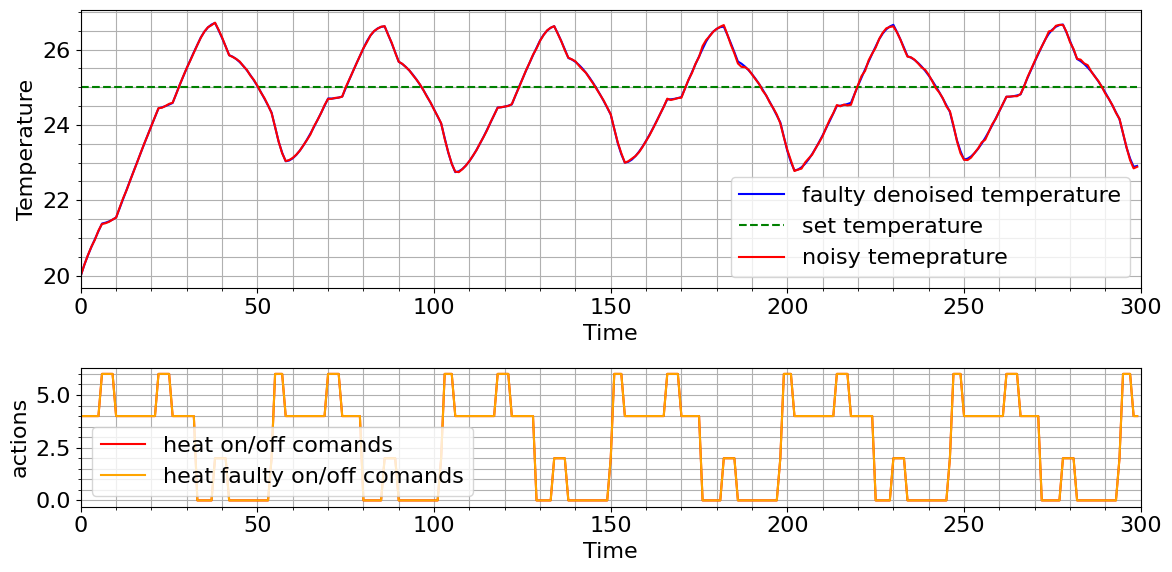

-14.949999999999989

In [ ]:
n0=0
t_set=298.15-kelvin
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(12)
fig.set_figheight(6)
axs[0].plot(t_f[n0], 'b',label="faulty denoised temperature")
#axs[0].plot(t_out_f[n0], 'black',label="outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="set temperature",linestyle='dashed')
axs[0].plot(noisy_t_f[n0], 'r',label="noisy temeprature")
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend()
axs[1].plot(a_f[n0], 'r',label="heat on/off comands")
#axs[1].plot(vent_f[0], 'b',label="ventilation on/off comands")
axs[1].plot(a_fault[n0], 'orange',label="heat faulty on/off comands")
#axs[1].plot(vent_fault[0], 'green',label="ventilation faulty on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()
plt.show()
t_out_f[n0,0]

In [ ]:
num=fault_type
level="low"
dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise.npz"

np.savez_compressed(dir, t_out_f=t_out_f, t_f=t_f,noisy_t_f=noisy_t_f,a_f=a_f,a_fault=a_fault)

# Data uploading

## train and test datasets

In [5]:
def prepare_dataset(npz_path, number_of_hid_units=3, size=-1):
    """
    Loads and reformats the dataset from the given npz file.
    Expected keys in the npz file:
      - t_out_c: outdoor temperature, shape (batch_size, session_length)
      - t_c: true indoor temperature (unused here)
      - noisy_t_c: observed indoor temperature, shape (batch_size, session_length)
      - a_c: HVAC actions, shape (batch_size, session_length)

    Returns a dictionary with keys:
      - 'actions': shape (batch_size, session_length), int32.
      - 'states':  shape (batch_size, session_length), float32.
      - 't_out':   shape (batch_size, session_length), float32.
      - 'eps':     shape (batch_size, session_length), float32.
      - 'initial_state': shape (batch_size, number_of_hid_units), float32.
    """
    data = np.load(npz_path)
    t_out_c = data["t_out_c"][:size,:]
    noisy_t_c = data["noisy_t_c"][:size,:]
    a_c = data["a_c"][:size,:]
    

    batch_size, session_length = noisy_t_c.shape
    eps = np.random.randn(batch_size, session_length).astype(np.float32)
    initial_state = np.random.randn(batch_size, number_of_hid_units).astype(np.float32)

    dataset_dict = {
        "actions": a_c.astype(np.int32),
        "states": noisy_t_c.astype(np.float32),
        "t_out": t_out_c.astype(np.float32),
        "eps": eps,
        "initial_state": initial_state
    }
    return dataset_dict
def prepare_dataset_from_split(npz_prefix, number_of_hid_units=3, size=-1):
    """
    Loads and reformats the dataset from multiple split npz files.
    Expected keys in each npz file:
      - t_out_c: outdoor temperature, shape (batch_size, session_length)
      - t_c: true indoor temperature (unused here)
      - noisy_t_c: observed indoor temperature, shape (batch_size, session_length)
      - a_c: HVAC actions, shape (batch_size, session_length)

    Args:
        npz_prefix: The prefix used to generate the split npz files (e.g., 'output_prefix' for files like 'output_prefix_part_1.npz')
        number_of_hid_units: Number of hidden units for the initial state.
        size: Number of samples to use (-1 for all).

    Returns a dictionary with keys:
      - 'actions': shape (batch_size, session_length), int32.
      - 'states':  shape (batch_size, session_length), float32.
      - 't_out':   shape (batch_size, session_length), float32.
      - 'eps':     shape (batch_size, session_length), float32.
      - 'initial_state': shape (batch_size, number_of_hid_units), float32.
    """
    # Find all split files matching the pattern
    split_files = glob.glob(f"{npz_prefix}_part_*.npz")
    if not split_files:
        raise ValueError(f"No split files found with prefix: {npz_prefix}")

    # Initialize lists to hold data from each split file
    t_out_c_list = []
    noisy_t_c_list = []
    a_c_list = []
    t_c_list = []

    # Load and concatenate data from each split file
    for file in sorted(split_files):
        data = np.load(file)
        t_out_c_list.append(data["t_out_c"])
        noisy_t_c_list.append(data["noisy_t_c"])
        a_c_list.append(data["a_c"])
        t_c_list.append(data["t_c"])

    # Concatenate along the batch dimension (axis=0)
    t_out_c = np.concatenate(t_out_c_list, axis=0)
    noisy_t_c = np.concatenate(noisy_t_c_list, axis=0)
    a_c = np.concatenate(a_c_list, axis=0)
    t_c = np.concatenate(t_c_list, axis=0)

    # Apply size limit if specified
    if size > 0:
        t_out_c = t_out_c[:size, :]
        noisy_t_c = noisy_t_c[:size, :]
        a_c = a_c[:size, :]
        t_c = t_c[:size, :]

    batch_size, session_length = noisy_t_c.shape
    eps = np.random.randn(batch_size, session_length).astype(np.float32)
    initial_state = np.random.randn(batch_size, number_of_hid_units).astype(np.float32)

    dataset_dict = {
        "actions": a_c.astype(np.int32),
        "states": noisy_t_c.astype(np.float32),
        "t_out": t_out_c.astype(np.float32),
        "true_states": t_c.astype(np.float32),
        "eps": eps,
        "initial_state": initial_state
    }
    return dataset_dict

def create_tf_dataset(dataset_dict, batch_size=2048*4):
    """
    Converts the dictionary into a tf.data.Dataset by slicing along the first dimension
    and batching. Each element will then have shape:
      - actions: (batch_size, session_length)
      - states:  (batch_size, session_length)
      - t_out:   (batch_size, session_length)
      - eps:     (batch_size, session_length)
      - initial_state: (batch_size, number_of_hid_units)
    """
    num_samples = len(dataset_dict['states'])
    buffer_size = min(100000, num_samples)
    ds = tf.data.Dataset.from_tensor_slices(dataset_dict)
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = ds.repeat()
    return ds



# Load and create datasets
train_data_dict = prepare_dataset_from_split("./dataset/train/data_set_full_v7", number_of_hid_units=number_of_hid_units, size=-1)
train_dataset = create_tf_dataset(train_data_dict,batch_size=2048*2)
test_data_dict = prepare_dataset_from_split("./dataset/test/data_set_full_v7_test", number_of_hid_units=number_of_hid_units)
test_dataset = create_tf_dataset(test_data_dict,batch_size=1024)

I0000 00:00:1746028351.486118    5509 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


## 2400 minute dataset

In [ ]:
test_data_dict = prepare_dataset("./data_set_full_v7_test_10x.npz", number_of_hid_units=number_of_hid_units)
test_dataset = create_tf_dataset(test_data_dict)

## DR dataset

In [ ]:
#data= "/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train.npz"
#data= "/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train_heating.npz"
data= "./data_set_full_v5_dr_train_cooling.npz"
#data= "/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr.npz"
test_data_dict = prepare_dataset(data, number_of_hid_units=number_of_hid_units)
test_dataset = create_tf_dataset(test_data_dict)



## Faulty data

In [ ]:
number_of_pieces = 1
session_length = 300

num=0
level="low"
dir="./data_set_fault_"+str(num)+"_"+str(level)+"_noise.npz"
test_data_dict = prepare_dataset(dir, number_of_hid_units=number_of_hid_units)
test_dataset = create_tf_dataset(test_data_dict)

# NN structure TF2.X

In [49]:
@register_keras_serializable()
class DenoisingDynamicsModel(tf.keras.Model):
    def __init__(self, session_length=session_length, number_of_hid_units=number_of_hid_units, **kwargs):
        """
        Constructs a model that first denoises the temperature (via a CNN)
        and then processes the denoised signal with a GRU and a fully connected (FC)
        network to compute the dynamics.
        """
        super(DenoisingDynamicsModel, self).__init__(**kwargs)
        self.session_length = session_length
        self.number_of_hid_units = number_of_hid_units
        
        # s is a constant; eta is a trainable parameter (both used in the loss)
        self.s = tf.constant(-5.0, dtype=tf.float32)
        self.eta = tf.Variable(-5.0, trainable=True, dtype=tf.float32, name='eta')

        # ---------------------------
        # Denoising CNN (using Conv1D layers)
        # ---------------------------
        # The CNN receives a tensor of shape (batch, session_length, 3)
        # (channels: [actions, states, t_out]) and outputs a tensor with 2 channels (mu and sigma).
        self.denoiser = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters=8, kernel_size=8, padding='same',
                                   activation=tf.nn.elu,
                                   kernel_initializer='he_uniform', dtype=tf.float32),
            tf.keras.layers.Conv1D(filters=32, kernel_size=8, padding='same',
                                   activation=tf.nn.elu,
                                   kernel_initializer='he_uniform', dtype=tf.float32),
            tf.keras.layers.Conv1D(filters=8, kernel_size=8, padding='same',
                                   activation=tf.nn.elu,
                                   kernel_initializer='he_uniform', dtype=tf.float32),
            tf.keras.layers.Conv1D(filters=2, kernel_size=8, padding='same',
                                   activation=None,
                                   kernel_initializer='he_uniform', dtype=tf.float32)
        ], name='denoiser')

        # ---------------------------
        # GRU for dynamics
        # ---------------------------
        # The GRU processes inputs of shape (batch, session_length, 6) where the channels are:
        # one-hot encoded actions (depth 4), the true state (computed from mu and sigma) and t_out.
        self.gru = tf.keras.layers.GRU(units=number_of_hid_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dtype=tf.float32)

        # Fully connected network (“dynamics_net”) implemented as time distributed dense layers.
        self.dense1 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(16, activation=tf.nn.elu,
                                  kernel_initializer='he_uniform', dtype=tf.float32))
        self.dense2 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(1, kernel_initializer='he_uniform', dtype=tf.float32))

    def build(self, input_shape):
        # input_shape is a dictionary; assume input_shape['actions'] is (batch, session_length)
        actions_shape = input_shape['actions']
        session_length = actions_shape[1]  # Use dynamic batch size (None) for building layers

        # Build the denoiser with input shape: (None, session_length, 3)
        denoiser_input_shape = (None, session_length, 3)
        self.denoiser.build(denoiser_input_shape)

        # Build the GRU with input shape: (None, session_length, 6)
        gru_input_shape = (None, session_length, 6)
        self.gru.build(gru_input_shape)

        # Build the dense layers; dense1 expects input shape (None, session_length, number_of_hid_units)
        dense_input_shape = (None, session_length, self.number_of_hid_units)
        self.dense1.build(dense_input_shape)
        self.dense2.build(self.dense1.compute_output_shape(dense_input_shape))

        super(DenoisingDynamicsModel, self).build(input_shape)

    def call(self, inputs, training=False):
        """
        Expects a dictionary with the following keys:
          - 'actions': shape (batch, session_length), int32.
          - 'states': shape (batch, session_length), float32.
          - 't_out': shape (batch, session_length), float32.
          - 'eps': shape (batch, session_length), float32.
          - 'initial_state': shape (batch, number_of_hid_units), float32.
        """
        actions = inputs['actions']
        states = inputs['states']
        t_out = inputs['t_out']
        eps = inputs['eps']
        initial_state = inputs['initial_state']

        # ---------------------------------------
        # 1. Denoising CNN part
        # ---------------------------------------
        x = tf.concat([
            tf.cast(tf.expand_dims(actions, -1), tf.float32),
            tf.expand_dims(states, -1),
            tf.expand_dims(t_out, -1)
        ], axis=-1)  # shape: (batch, session_length, 3)

        conv_out = self.denoiser(x)  # shape: (batch, session_length, 2)
        mu = conv_out[..., 0]        # shape: (batch, session_length)
        sigma = conv_out[..., 1]     # shape: (batch, session_length)

        # Compute true state: mu + exp(sigma/2) * eps.
        true_state = mu + tf.exp(sigma / 2) * eps

        # ---------------------------------------
        # 2. Dynamical system part (RNN + FC net)
        # ---------------------------------------
        one_hot_actions = tf.one_hot(actions, depth=4, dtype=tf.float32)
        input_transform = tf.concat([
            one_hot_actions,
            tf.expand_dims(true_state, -1),
            tf.expand_dims(t_out, -1)
        ], axis=-1)  # shape: (batch, session_length, 6)

        gru_outputs = self.gru(input_transform, initial_state=initial_state)
        rnn_out = gru_outputs[0]  # (batch, session_length, number_of_hid_units)

        dyn_out = self.dense1(rnn_out)    # (batch, session_length, 16)
        dyn_out = self.dense2(dyn_out)    # (batch, session_length, 1)
        dyn_out = tf.squeeze(dyn_out, axis=-1)  # (batch, session_length)

        new_state = dyn_out + true_state  # (batch, session_length)

        # ---------------------------------------
        # 3. Time shifting and loss computation
        # ---------------------------------------
        mu_shift = mu[:, 1:]
        sigma_shift = sigma[:, 1:]
        T = states[:, 1:]
        F = new_state[:, :-1]

        sigma_term = tf.exp(sigma_shift) * (1/(2 * tf.exp(self.s)) + 1/(2 * tf.exp(self.eta)))
        regularization_term = tf.square(mu_shift - F) / (2 * tf.exp(self.s))
        log_sigma_term = -sigma_shift / 2
        regression_term = tf.square(T - mu_shift) / (2 * tf.exp(self.eta))

        loss = tf.reduce_mean(sigma_term + regularization_term +
                              log_sigma_term + regression_term +
                              self.s/2 + self.eta/2)

        return {
            'loss': loss,
            'mu': mu,
            'sigma': sigma,
            'true_state': true_state,
            'new_state': new_state
        }

    def t_denoising(self, noisy_t, t_out, action):
        """Handles both single-sample and batch inputs"""

        # Ensure 3D shape: [batch, time, features]
        x = tf.concat([
            tf.cast(tf.expand_dims(action, -1), tf.float32),
            tf.expand_dims(noisy_t, -1),
            tf.expand_dims(t_out, -1)
        ], axis=-1)  # (session_length, 3)

        # Add batch dimension if single sample
        if tf.rank(x) == 2:
            x = tf.expand_dims(x, 0)

        conv_out = self.denoiser(x)  # [batch, time, 2]
        mu, sigma = tf.split(conv_out, 2, axis=-1)
        return tf.squeeze(mu), tf.exp(tf.squeeze(sigma)/2)

    def get_new_hidden_state(self, hidden_actions, hidden_states, hidden_t_out):
        """Processes batches and single samples"""
        # Convert to 3D: [batch, time, features]
        x = tf.concat([
            tf.one_hot(hidden_actions, depth=4),          # [..., 4]
            tf.expand_dims(hidden_states, -1),            # [..., 1]
            tf.expand_dims(hidden_t_out, -1)              # [..., 1]
        ], axis=-1)

        # Add batch dim if single sample
        if tf.rank(x) == 2:
            x = tf.expand_dims(x, 0)

        # Process through GRU - returns [batch, time, units]
        gru_output = self.gru(x)
       
        
        # Case 1: Multiple states returned (one per sample)
        if len(gru_output) > 2:
            # Stack all individual states into a single tensor
            final_state = tf.stack(gru_output[1:])  # [batch, units]
            return final_state
        # Case 2: Standard (outputs, state) tuple
        elif len(gru_output) == 2:
            return gru_output[1]

    def predict_next_state(self, pred_actions, pred_states, pred_t_out, initial_state):
        """Batch-friendly prediction step"""
        # Ensure all tensors have matching batch dimensions
        # Create input features [batch, 1, 6]
        x = tf.concat([
            tf.one_hot(pred_actions, depth=4),          # [..., 4]
            tf.expand_dims(pred_states, -1),            # [..., 1]
            tf.expand_dims(pred_t_out, -1)              # [..., 1]
        ], axis=-1)
        
        # Ensure proper 3D shape
        if tf.rank(x) == 1:
            x = tf.expand_dims(x, 0)  # [1, 6] -> [1, 1, 6]
            x = tf.expand_dims(x, 0)
        elif tf.rank(x) == 2:
            x = tf.expand_dims(x, 1)  # [batch, 6] -> [batch, 1, 6]


        # GRU step - outputs: [batch, 1, units]
        gru_output = self.gru(x, initial_state=initial_state)
        if len(gru_output) > 2:
            # Stack all individual states into a single tensor
            new_hidden_state = tf.stack(gru_output[1:])  # [batch, units]
        # Case 2: Standard (outputs, state) tuple
        elif len(gru_output) == 2:
            new_hidden_state=gru_output[1]
        # Dense layers and output
        delta = self.dense2(self.dense1(gru_output[0]))  # [batch, 1, 1]
        return tf.squeeze(delta, [1, 2]), new_hidden_state  # [batch], [batch, units]


model = DenoisingDynamicsModel(session_length=session_length, number_of_hid_units=number_of_hid_units)
initial_learning_rate = 0.0005 # this method is sensitive to exploiding gradient, so an starting learning rate of 0.05 or less is recommended, for finetuning 0.0001 is recommended
decay_steps = 1000 # as the model is data efficient, too large decay steps slow dow learning 
decay_rate = 0.97
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)


def train_model(model, dataset, optimizer, num_steps=10000, plot_interval=100):
    """
    Train model while properly iterating through all batches
    
    Args:
        model: Model to train
        dataset: TF Dataset (should be shuffled and batched)
        optimizer: TF Optimizer
        num_steps: Total training steps
        plot_interval: How often to log progress
        
    Returns:
        losses: List of loss values during training
    """
    losses = []
    best_loss = float('inf')
    best_weights = None
    
    # Create iterator that will cycle through the dataset
    data_iterator = iter(dataset.repeat())
    
    repeatcount=0

    for step in tqdm(range(num_steps), desc='Training', leave=True):
        try:
            # Get next batch (will cycle through dataset)
            batch = next(data_iterator)
        except StopIteration:
            # Handle case where dataset is exhausted
            data_iterator = iter(dataset.repeat())
            batch = next(data_iterator)
            repeatcount=repeatcount+1
            print("full batch interation",repeatcount)
        
        with tf.device('/GPU:0'):
            with tf.GradientTape() as tape:
                outputs = model(batch, training=True)
                loss = outputs['loss']
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            current_loss = loss.numpy()
            losses.append(current_loss)

            # Track best weights
            if current_loss < best_loss:
                best_loss = current_loss
                best_weights = model.get_weights()  # Creates a copy
                print(f"New best loss at step {step}: {best_loss:.4f}")
                model.save('./models/Model_V9_best_train.keras')

        if step % plot_interval == 0 and step > 0:
            # Calculate average loss over last plot_interval steps
            avg_loss = np.mean(losses[-plot_interval:])
            print(f"Step {step}: Current loss {current_loss:.4f}, Avg loss {avg_loss:.4f}")
    
    # Restore best weights at the end of training
    if best_weights is not None:
        model.set_weights(best_weights)
        print(f"Training complete. Restored weights with best loss: {best_loss:.4f}")
    
    return losses,repeatcount



# training loop



In [51]:
with tf.device('/GPU:0'):
    losses,repeatcount = train_model(model, train_dataset, optimizer, num_steps=100000, plot_interval=100)


Training:   0%|          | 0/100000 [00:00<?, ?it/s]

New best loss at step 0: -0.3775
New best loss at step 62: -0.3864
New best loss at step 99: -0.3954
Step 100: Current loss -0.3387, Avg loss 1.1472
New best loss at step 156: -0.3970
New best loss at step 189: -0.4020
Step 200: Current loss -0.3732, Avg loss -0.3697
New best loss at step 257: -0.4056
New best loss at step 286: -0.4078
Step 300: Current loss -0.3905, Avg loss -0.3708
Step 400: Current loss -0.3645, Avg loss -0.3682
Step 500: Current loss -0.3522, Avg loss -0.3683
Step 600: Current loss -0.3758, Avg loss -0.3684
Step 700: Current loss -0.3747, Avg loss -0.3658
New best loss at step 736: -0.4095
Step 800: Current loss -0.3808, Avg loss -0.3686
New best loss at step 811: -0.4099
Step 900: Current loss -0.3975, Avg loss -0.3715
New best loss at step 924: -0.4203
Step 1000: Current loss -0.3791, Avg loss -0.3626
Step 1100: Current loss -0.3061, Avg loss -0.3556
Step 1200: Current loss -0.3036, Avg loss -0.3471
Step 1300: Current loss -0.3647, Avg loss -0.3403
Step 1400: Cur

2025-05-01 01:24:51.120315: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:25:07.553836: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:25:24.068583: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43000: Current loss -0.4018, Avg loss -0.4112


2025-05-01 01:25:56.867942: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:26:13.299139: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:26:29.723586: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43100: Current loss -0.3887, Avg loss -0.4096


2025-05-01 01:27:02.581293: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:27:19.070931: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:27:35.505613: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43200: Current loss -0.2974, Avg loss -0.3742


2025-05-01 01:28:08.456689: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:28:24.884019: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:28:41.207021: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43300: Current loss -0.4087, Avg loss -0.3816


2025-05-01 01:29:14.116867: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:29:30.559377: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:29:47.017775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43400: Current loss -0.3970, Avg loss -0.3974


2025-05-01 01:30:19.862068: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:30:36.273175: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:30:52.722432: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43500: Current loss -0.3608, Avg loss -0.3755


2025-05-01 01:31:25.535395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:31:41.967354: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:31:58.427490: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43600: Current loss -0.3948, Avg loss -0.3854


2025-05-01 01:32:31.384263: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:32:47.804664: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:33:04.292614: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43700: Current loss -0.4187, Avg loss -0.4038


2025-05-01 01:33:37.246613: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:33:53.738086: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:34:10.057987: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43800: Current loss -0.4106, Avg loss -0.4124


2025-05-01 01:34:42.962869: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:34:59.407926: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:35:15.859033: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 43900: Current loss -0.4030, Avg loss -0.3728


2025-05-01 01:35:48.717739: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:36:05.201527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:36:21.613936: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44000: Current loss -0.2470, Avg loss -0.3549


2025-05-01 01:36:54.407408: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:37:10.848085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:37:27.273737: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44100: Current loss -0.4349, Avg loss -0.2632


2025-05-01 01:38:00.195580: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:38:16.678566: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:38:33.076949: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44200: Current loss -0.2115, Avg loss -0.3153


2025-05-01 01:39:05.966924: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:39:22.436576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:39:38.767363: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44300: Current loss -0.3972, Avg loss -0.3949


2025-05-01 01:40:11.628984: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:40:28.095961: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:40:44.548638: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44400: Current loss -0.4304, Avg loss -0.4025


2025-05-01 01:41:17.412329: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:41:33.861513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:41:50.320153: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44500: Current loss -0.3002, Avg loss -0.3740


2025-05-01 01:42:23.147578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:42:39.591588: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:42:56.022966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44600: Current loss -0.4277, Avg loss -0.3505


2025-05-01 01:43:28.995830: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:43:45.424134: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:44:01.909235: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44700: Current loss -0.2609, Avg loss -0.3622


2025-05-01 01:44:34.857897: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:44:51.322133: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:45:07.680668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44800: Current loss -0.4195, Avg loss -0.4053


2025-05-01 01:45:40.516844: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:45:56.980222: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:46:13.431097: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 44900: Current loss -0.3673, Avg loss -0.4005


2025-05-01 01:46:46.322009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:47:02.792729: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:47:19.244206: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45000: Current loss -0.4069, Avg loss -0.4074


2025-05-01 01:47:52.101121: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:48:08.564163: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:48:25.009771: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45100: Current loss -0.4160, Avg loss -0.3929


2025-05-01 01:48:57.957224: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:49:14.431615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:49:30.842642: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45200: Current loss -0.3802, Avg loss -0.3758


2025-05-01 01:50:03.739636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:50:20.235671: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:50:36.592557: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45300: Current loss -0.4067, Avg loss -0.3905


2025-05-01 01:51:09.492792: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:51:25.929635: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:51:42.387896: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45400: Current loss -0.3962, Avg loss -0.4095


2025-05-01 01:52:15.306570: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:52:31.778847: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:52:48.238419: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45500: Current loss -0.3802, Avg loss -0.3649


2025-05-01 01:53:21.069841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:53:37.565756: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:53:54.032114: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45600: Current loss -0.3388, Avg loss -0.3768


2025-05-01 01:54:27.053482: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:54:43.579765: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:55:00.035671: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45700: Current loss -0.3803, Avg loss -0.4027


2025-05-01 01:55:32.938958: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:55:49.410204: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:56:05.781890: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45800: Current loss -0.4222, Avg loss -0.4020


2025-05-01 01:56:38.758822: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:56:55.280828: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:57:11.740236: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 45900: Current loss -0.3863, Avg loss -0.3715


2025-05-01 01:57:44.664744: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:58:01.166262: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:58:17.659142: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46000: Current loss -0.3992, Avg loss -0.4075


2025-05-01 01:58:50.488626: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:59:07.005864: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 01:59:23.497956: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46100: Current loss -0.4206, Avg loss -0.3869


2025-05-01 01:59:56.439960: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:00:12.913017: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:00:29.384529: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46200: Current loss -0.3029, Avg loss -0.3899


2025-05-01 02:01:02.331084: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:01:18.858402: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:01:35.244263: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46300: Current loss -0.4150, Avg loss -0.3774


2025-05-01 02:02:08.178120: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:02:24.702215: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:02:41.212976: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46400: Current loss -0.3897, Avg loss -0.4116


2025-05-01 02:03:14.135966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:03:30.645191: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:03:47.110303: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46500: Current loss -0.3846, Avg loss -0.4130


2025-05-01 02:04:19.979491: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:04:36.436277: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:04:52.909533: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46600: Current loss -0.1683, Avg loss -0.1425


2025-05-01 02:05:25.948194: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:05:42.450911: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:05:58.952084: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46700: Current loss -0.4164, Avg loss -0.3962


2025-05-01 02:06:31.955749: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:06:48.429997: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:07:04.761666: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46800: Current loss -0.3769, Avg loss -0.3954


2025-05-01 02:07:37.743578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:07:54.254821: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:08:10.737836: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 46900: Current loss -0.3991, Avg loss -0.4048


2025-05-01 02:08:43.721311: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:09:00.222415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:09:16.713296: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47000: Current loss -0.4235, Avg loss -0.4093


2025-05-01 02:09:49.546100: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:10:06.031960: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:10:22.570582: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47100: Current loss -0.4387, Avg loss -0.4149


2025-05-01 02:10:55.551222: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:11:12.034982: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:11:28.516647: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47200: Current loss -0.3730, Avg loss -0.3128


2025-05-01 02:12:01.512548: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:12:18.020985: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:12:34.393327: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47300: Current loss -0.3980, Avg loss -0.4124


2025-05-01 02:13:07.402328: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:13:23.919945: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:13:40.366700: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47400: Current loss -0.3976, Avg loss -0.4057


2025-05-01 02:14:13.299754: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:14:29.810205: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:14:46.268202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47500: Current loss -0.4295, Avg loss -0.4029


2025-05-01 02:15:19.149474: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:15:35.673153: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:15:52.204507: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47600: Current loss -0.3855, Avg loss -0.4117


2025-05-01 02:16:25.262262: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:16:41.751387: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:16:58.256222: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47700: Current loss -0.4226, Avg loss -0.4112


2025-05-01 02:17:31.304750: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:17:47.866709: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:18:04.269893: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47800: Current loss -0.4417, Avg loss -0.4114


2025-05-01 02:18:37.282291: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:18:53.802777: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:19:10.309780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 47900: Current loss -0.3787, Avg loss -0.3785


2025-05-01 02:19:43.303732: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:19:59.765155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:20:16.261448: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48000: Current loss -0.4314, Avg loss -0.3609


2025-05-01 02:20:49.217240: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:21:05.752514: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:21:22.248173: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48100: Current loss -0.3638, Avg loss -0.3935


2025-05-01 02:21:55.269637: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:22:11.796410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:22:28.374390: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48200: Current loss -0.4213, Avg loss -0.4046


2025-05-01 02:23:01.379789: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:23:17.933085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:23:34.355728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48300: Current loss -0.4143, Avg loss -0.4073


2025-05-01 02:24:07.344763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:24:23.912822: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:24:40.450064: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48400: Current loss -0.4295, Avg loss -0.4037


2025-05-01 02:25:13.436574: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:25:29.896717: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:25:46.412137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48500: Current loss -0.3955, Avg loss -0.3986


2025-05-01 02:26:19.366775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:26:35.892870: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:26:52.403707: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48600: Current loss -0.3920, Avg loss -0.3946


2025-05-01 02:27:25.422515: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:27:41.989047: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:27:58.484144: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48700: Current loss -0.4019, Avg loss -0.3999


2025-05-01 02:28:31.527652: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:28:48.095227: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:29:04.531965: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48800: Current loss -0.4142, Avg loss -0.4069


2025-05-01 02:29:37.586385: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:29:54.163663: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:30:10.690850: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 48900: Current loss -0.4150, Avg loss -0.4043


2025-05-01 02:30:43.683812: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:31:00.163830: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:31:16.650917: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49000: Current loss -0.4297, Avg loss -0.3966


2025-05-01 02:31:49.525816: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:32:06.029291: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:32:22.520161: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49100: Current loss -0.4153, Avg loss -0.4010


2025-05-01 02:32:55.581594: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:33:12.075944: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:33:28.623186: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49200: Current loss -0.1829, Avg loss -0.3477


2025-05-01 02:34:01.667667: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:34:18.199068: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:34:34.603558: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49300: Current loss -0.4215, Avg loss -0.3625


2025-05-01 02:35:07.628847: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:35:24.177940: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:35:40.689740: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49400: Current loss -0.4034, Avg loss -0.3944


2025-05-01 02:36:13.780691: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:36:30.313809: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:36:46.824959: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49500: Current loss -0.4280, Avg loss -0.4088


2025-05-01 02:37:19.768824: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:37:36.318673: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:37:52.857754: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49600: Current loss -0.3916, Avg loss -0.3834


2025-05-01 02:38:25.891827: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:38:42.432858: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:38:58.972753: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49700: Current loss -0.3434, Avg loss -0.3404


2025-05-01 02:39:32.030336: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:39:48.563249: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:40:04.951769: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49800: Current loss -0.4069, Avg loss -0.3833


2025-05-01 02:40:38.044908: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:40:54.570289: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:41:11.087728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 49900: Current loss -0.4004, Avg loss -0.3952


2025-05-01 02:41:44.109669: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:42:00.641386: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:42:17.157644: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50000: Current loss -0.3408, Avg loss -0.3774


2025-05-01 02:42:50.141887: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:43:06.630254: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:43:23.152713: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50100: Current loss -0.3817, Avg loss -0.4046


2025-05-01 02:43:56.243757: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:44:12.755389: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:44:29.288958: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50200: Current loss -0.3164, Avg loss -0.3399


2025-05-01 02:45:02.357790: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:45:18.876835: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:45:35.273219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50300: Current loss -0.4117, Avg loss -0.3559


2025-05-01 02:46:08.377445: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:46:24.918608: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:46:41.458657: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50400: Current loss -0.4144, Avg loss -0.4110


2025-05-01 02:47:14.487327: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:47:31.025571: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:47:47.550220: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50500: Current loss -0.3897, Avg loss -0.3065


2025-05-01 02:48:20.537515: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:48:37.059299: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:48:53.583275: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50600: Current loss -0.2232, Avg loss -0.3869


2025-05-01 02:49:26.664456: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:49:43.215833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:49:59.768983: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50700: Current loss -0.3850, Avg loss -0.3682


2025-05-01 02:50:32.889765: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:50:49.513022: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:51:05.928646: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50800: Current loss -0.3661, Avg loss -0.3744


2025-05-01 02:51:38.997752: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:51:55.574978: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:52:12.106826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 50900: Current loss -0.3982, Avg loss -0.3761


2025-05-01 02:52:45.210348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:53:01.747276: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:53:18.277033: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51000: Current loss -0.4202, Avg loss -0.3967


2025-05-01 02:53:51.363555: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:54:07.884841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:54:24.410910: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51100: Current loss -0.4145, Avg loss -0.3825


2025-05-01 02:54:57.504311: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:55:14.031468: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:55:30.565467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51200: Current loss -0.4255, Avg loss -0.3747


2025-05-01 02:56:03.606356: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:56:20.184143: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:56:36.588909: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51300: Current loss -0.4111, Avg loss -0.4041


2025-05-01 02:57:09.636124: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:57:26.200233: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:57:42.738169: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51400: Current loss -0.4068, Avg loss -0.4061


2025-05-01 02:58:15.820435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:58:32.373687: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:58:48.910771: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51500: Current loss -0.4078, Avg loss -0.4116


2025-05-01 02:59:21.901299: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:59:38.428416: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 02:59:54.942962: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51600: Current loss -0.4053, Avg loss -0.4154


2025-05-01 03:00:28.016268: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:00:44.610974: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:01:01.152481: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51700: Current loss -0.4050, Avg loss -0.4155


2025-05-01 03:01:34.248963: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:01:50.812994: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:02:07.256167: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51800: Current loss -0.4270, Avg loss -0.3981


2025-05-01 03:02:40.330349: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:02:56.891137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:03:13.437068: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 51900: Current loss -0.4118, Avg loss -0.4088


2025-05-01 03:03:46.507135: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:04:03.028043: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:04:19.581533: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52000: Current loss -0.4273, Avg loss -0.4082


2025-05-01 03:04:52.579064: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:05:09.110674: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:05:25.632401: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52100: Current loss -0.3720, Avg loss -0.3937


2025-05-01 03:05:58.708426: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:06:15.269906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:06:31.817469: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52200: Current loss -0.4166, Avg loss -0.3682


2025-05-01 03:07:04.895466: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:07:21.466506: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:07:37.892288: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52300: Current loss -0.3829, Avg loss -0.3991


2025-05-01 03:08:11.018213: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:08:27.572580: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:08:44.120989: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52400: Current loss -0.4026, Avg loss -0.4057


2025-05-01 03:09:17.187728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:09:33.721666: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:09:50.280939: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52500: Current loss -0.3383, Avg loss -0.3853


2025-05-01 03:10:23.399848: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:10:39.990681: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:10:56.581544: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52600: Current loss -0.4065, Avg loss -0.3828


2025-05-01 03:11:29.692826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:11:46.207498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:12:02.729390: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52700: Current loss -0.3939, Avg loss -0.3107


2025-05-01 03:12:35.857134: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:12:52.419407: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:13:08.881009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52800: Current loss -0.3823, Avg loss -0.3759


2025-05-01 03:13:42.006710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:13:58.586324: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:14:15.169695: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 52900: Current loss -0.4074, Avg loss -0.3905


2025-05-01 03:14:48.340478: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:15:04.874415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:15:21.451419: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53000: Current loss -0.4088, Avg loss -0.3905


2025-05-01 03:15:54.514937: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:16:11.063714: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:16:27.637918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53100: Current loss -0.3987, Avg loss -0.3749


2025-05-01 03:17:00.764918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:17:17.313583: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:17:33.867771: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53200: Current loss -0.4078, Avg loss -0.4097


2025-05-01 03:18:06.979652: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:18:23.548907: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:18:40.004954: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53300: Current loss -0.4249, Avg loss -0.3924


2025-05-01 03:19:13.181710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:19:29.747418: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:19:46.323847: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53400: Current loss -0.3877, Avg loss -0.4002


2025-05-01 03:20:19.450042: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:20:35.998924: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:20:52.593964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53500: Current loss -0.4169, Avg loss -0.4079


2025-05-01 03:21:25.704673: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:21:42.292751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:21:58.841775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53600: Current loss -0.4072, Avg loss -0.4108


2025-05-01 03:22:31.987858: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:22:48.563016: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:23:05.114424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53700: Current loss -0.4166, Avg loss -0.4139


2025-05-01 03:23:38.270944: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:23:54.844926: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:24:11.258709: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53800: Current loss -0.4083, Avg loss -0.4039


2025-05-01 03:24:44.433794: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:25:01.054074: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:25:17.656557: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 53900: Current loss -0.4092, Avg loss -0.3957


2025-05-01 03:25:50.761119: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:26:07.327409: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:26:23.902065: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54000: Current loss -0.3762, Avg loss -0.4045


2025-05-01 03:26:56.964134: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:27:13.512609: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:27:30.096713: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54100: Current loss -0.3054, Avg loss -0.2735


2025-05-01 03:28:03.227181: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:28:19.788610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:28:36.320209: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54200: Current loss -0.4077, Avg loss -0.1829


2025-05-01 03:29:09.462578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:29:26.063275: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:29:42.538828: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54300: Current loss -0.4085, Avg loss -0.4144


2025-05-01 03:30:15.745905: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:30:32.362746: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:30:48.941263: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54400: Current loss -0.4057, Avg loss -0.4083


2025-05-01 03:31:22.136267: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:31:38.736290: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:31:55.340203: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54500: Current loss -0.4154, Avg loss -0.4163


2025-05-01 03:32:28.390409: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:32:44.972228: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:33:01.582881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54600: Current loss -0.4081, Avg loss -0.4132


2025-05-01 03:33:34.787059: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:33:51.384541: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:34:07.986608: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54700: Current loss -0.3467, Avg loss -0.3743


2025-05-01 03:34:41.182267: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:34:57.766668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:35:14.239443: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54800: Current loss -0.4188, Avg loss -0.4050


2025-05-01 03:35:47.418444: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:36:04.026434: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:36:20.611663: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 54900: Current loss -0.3912, Avg loss -0.4128


2025-05-01 03:36:53.793487: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:37:10.370787: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:37:26.951212: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55000: Current loss -0.4308, Avg loss -0.4105


2025-05-01 03:38:00.023366: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:38:16.583042: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:38:33.176719: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55100: Current loss -0.4311, Avg loss -0.4170


2025-05-01 03:39:06.414502: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:39:23.009214: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:39:39.627587: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55200: Current loss -0.4040, Avg loss -0.3533


2025-05-01 03:40:12.830219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:40:29.428965: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:40:45.862280: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55300: Current loss -0.4087, Avg loss -0.4165


2025-05-01 03:41:19.059002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:41:35.674752: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:41:52.267215: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55400: Current loss -0.3831, Avg loss -0.2900


2025-05-01 03:42:25.477771: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:42:42.071803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:42:58.752326: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55500: Current loss -0.4145, Avg loss -0.4128


2025-05-01 03:43:31.896111: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:43:48.475377: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:44:05.120020: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55600: Current loss -0.3958, Avg loss -0.4102


2025-05-01 03:44:38.386085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:44:55.027575: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:45:11.652612: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55700: Current loss -0.4080, Avg loss -0.3300


2025-05-01 03:45:44.854251: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:46:01.458197: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:46:17.967207: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55800: Current loss -0.4056, Avg loss -0.4149


2025-05-01 03:46:51.131439: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


New best loss at step 55824: -0.4740


2025-05-01 03:47:07.789947: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:47:24.440053: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:47:41.047186: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 55900: Current loss -0.3870, Avg loss -0.4071


2025-05-01 03:47:57.712401: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:48:14.331333: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:48:30.850379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56000: Current loss -0.3794, Avg loss -0.4050


2025-05-01 03:49:04.140049: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:49:20.729380: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:49:37.338509: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56100: Current loss -0.3862, Avg loss -0.4074


2025-05-01 03:50:10.545645: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:50:27.079646: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:50:43.676840: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56200: Current loss -0.4052, Avg loss -0.4168


2025-05-01 03:51:16.940668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:51:33.570881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:51:50.164562: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56300: Current loss -0.3933, Avg loss -0.4140


2025-05-01 03:52:23.312815: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:52:39.977521: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:52:56.562993: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56400: Current loss -0.3398, Avg loss -0.4119


2025-05-01 03:53:29.852684: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:53:46.484931: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:54:03.133748: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56500: Current loss -0.4094, Avg loss -0.3616


2025-05-01 03:54:36.327313: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:54:52.960716: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:55:09.589508: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56600: Current loss -0.3475, Avg loss -0.4007


2025-05-01 03:55:42.886972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:55:59.500094: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:56:15.996786: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56700: Current loss -0.2230, Avg loss -0.3500


2025-05-01 03:56:49.248875: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:57:05.929879: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:57:22.517995: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56800: Current loss -0.4031, Avg loss -0.3538


2025-05-01 03:57:55.740617: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:58:12.253816: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:58:28.862219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 56900: Current loss -0.4335, Avg loss -0.3574


2025-05-01 03:59:02.119555: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:59:18.795609: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 03:59:35.418708: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57000: Current loss -0.3820, Avg loss -0.3924


2025-05-01 04:00:08.569279: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:00:25.214300: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:00:41.826560: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57100: Current loss -0.3922, Avg loss -0.4029


2025-05-01 04:01:15.109778: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:01:31.717636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:01:48.339278: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57200: Current loss -0.4220, Avg loss -0.4039


2025-05-01 04:02:21.557042: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:02:38.211728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:02:54.832328: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57300: Current loss -0.3817, Avg loss -0.4058


2025-05-01 04:03:28.079804: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:03:44.690745: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:04:01.214943: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57400: Current loss -0.4221, Avg loss -0.3348


2025-05-01 04:04:34.461888: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:04:51.067937: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:05:07.725045: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57500: Current loss -0.4279, Avg loss -0.3334


2025-05-01 04:05:41.013986: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:05:57.563457: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:06:14.178780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57600: Current loss -0.4338, Avg loss -0.4114


2025-05-01 04:06:47.477950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:07:04.100967: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:07:20.784185: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57700: Current loss -0.3730, Avg loss -0.4119


2025-05-01 04:07:54.010785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:08:10.668496: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:08:27.289589: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57800: Current loss -0.4038, Avg loss -0.3997


2025-05-01 04:09:00.589580: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:09:17.242327: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:09:33.860828: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 57900: Current loss -0.3699, Avg loss -0.3743


2025-05-01 04:10:07.014501: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:10:23.693077: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:10:40.288308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 58000: Current loss -0.3543, Avg loss -0.3984


2025-05-01 04:11:13.610036: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:11:30.235116: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:11:46.724715: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 58100: Current loss -0.3859, Avg loss -0.3459


2025-05-01 04:12:20.000162: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:12:36.628517: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:12:53.268926: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 58200: Current loss -0.3435, Avg loss -0.3685


2025-05-01 04:13:26.524827: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:13:43.033566: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:13:59.635949: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 58300: Current loss -0.2526, Avg loss -0.3463


2025-05-01 04:14:32.945819: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:14:49.549046: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:15:06.211211: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 58400: Current loss -0.3972, Avg loss -0.3843


2025-05-01 04:15:39.397384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:15:56.076397: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:16:12.720862: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 58500: Current loss -0.4061, Avg loss -0.3939


2025-05-01 04:16:45.959143: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:17:02.644631: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


New best loss at step 58549: -0.4838


2025-05-01 04:17:19.333041: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:17:35.850296: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Step 58600: Current loss -0.3896, Avg loss -0.4029


2025-05-01 04:17:52.459276: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:18:09.088997: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:18:25.762060: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 58700: Current loss -0.4067, Avg loss -0.4042


2025-05-01 04:18:59.056741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:19:15.702375: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:19:32.363392: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 58800: Current loss -0.4290, Avg loss -0.4103


2025-05-01 04:20:05.638922: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:20:22.170634: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:20:38.824569: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 58900: Current loss -0.3854, Avg loss -0.4137


2025-05-01 04:21:12.113496: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:21:28.826741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:21:45.455899: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59000: Current loss -0.3900, Avg loss -0.4105


2025-05-01 04:22:18.729934: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:22:35.356515: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:22:52.040751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59100: Current loss -0.4151, Avg loss -0.4086


2025-05-01 04:23:25.269787: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:23:41.903826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:23:58.569277: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59200: Current loss -0.4421, Avg loss -0.4155


2025-05-01 04:24:31.852478: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:24:48.496345: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:25:05.144007: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59300: Current loss -0.4124, Avg loss -0.4162


2025-05-01 04:25:38.485840: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:25:55.024620: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:26:11.630783: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59400: Current loss -0.3581, Avg loss -0.4133


2025-05-01 04:26:44.920856: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:27:01.552221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:27:18.212837: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59500: Current loss -0.4193, Avg loss -0.4001


2025-05-01 04:27:51.524368: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:28:08.187463: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:28:24.852001: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59600: Current loss -0.3734, Avg loss -0.4073


2025-05-01 04:28:58.041259: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:29:14.733707: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:29:31.419695: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59700: Current loss -0.3874, Avg loss -0.3958


2025-05-01 04:30:04.785736: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:30:21.423010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:30:38.059184: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59800: Current loss -0.3388, Avg loss -0.3571


2025-05-01 04:31:11.318487: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:31:27.871478: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:31:44.509572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 59900: Current loss -0.4174, Avg loss -0.3915


2025-05-01 04:32:17.820087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:32:34.441328: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:32:51.115473: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60000: Current loss -0.4252, Avg loss -0.3908


2025-05-01 04:33:24.521622: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:33:41.146527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:33:57.833114: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60100: Current loss -0.4117, Avg loss -0.4077


2025-05-01 04:34:31.033632: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:34:47.679465: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:35:04.377103: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60200: Current loss -0.3734, Avg loss -0.3954


2025-05-01 04:35:37.715127: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:35:54.363113: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:36:10.982464: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60300: Current loss -0.4178, Avg loss -0.3924


2025-05-01 04:36:44.357328: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:37:00.925940: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:37:17.586782: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60400: Current loss -0.3673, Avg loss -0.4010


2025-05-01 04:37:50.944866: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:38:07.584615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:38:24.233330: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60500: Current loss -0.4003, Avg loss -0.3807


2025-05-01 04:38:57.515775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:39:14.221053: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:39:30.917264: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60600: Current loss -0.3705, Avg loss -0.3883


2025-05-01 04:40:04.091932: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:40:20.723432: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:40:37.383437: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60700: Current loss -0.3891, Avg loss -0.4020


2025-05-01 04:41:10.696381: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:41:27.411362: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:41:44.067547: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60800: Current loss -0.4292, Avg loss -0.3986


2025-05-01 04:42:17.445683: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:42:33.990611: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:42:50.626790: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 60900: Current loss -0.4279, Avg loss -0.3170


2025-05-01 04:43:23.965378: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:43:40.698804: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:43:57.348408: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61000: Current loss -0.3618, Avg loss -0.3991


2025-05-01 04:44:30.641975: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:44:47.313867: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:45:03.989589: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61100: Current loss -0.3959, Avg loss -0.3775


2025-05-01 04:45:37.185576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:45:53.827190: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:46:10.489635: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61200: Current loss -0.4076, Avg loss -0.3427


2025-05-01 04:46:43.809699: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:47:00.480875: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:47:17.197321: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61300: Current loss -0.3968, Avg loss -0.3727


2025-05-01 04:47:50.584741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:48:07.142377: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:48:23.823672: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61400: Current loss -0.3885, Avg loss -0.3612


2025-05-01 04:48:57.107859: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:49:13.778274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:49:30.436657: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61500: Current loss -0.4387, Avg loss -0.4022


2025-05-01 04:50:03.769689: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:50:20.409831: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:50:37.091630: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61600: Current loss -0.4199, Avg loss -0.4180


2025-05-01 04:51:10.312617: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:51:26.981810: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:51:43.673402: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61700: Current loss -0.4166, Avg loss -0.3891


2025-05-01 04:52:17.031996: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:52:33.693415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:52:50.352054: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61800: Current loss -0.4010, Avg loss -0.3974


2025-05-01 04:53:23.750218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:53:40.340535: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:53:57.018272: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 61900: Current loss -0.4082, Avg loss -0.4016


2025-05-01 04:54:30.385319: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:54:47.060547: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:55:03.734315: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62000: Current loss -0.4460, Avg loss -0.4152


2025-05-01 04:55:37.067573: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:55:53.732952: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:56:10.395443: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62100: Current loss -0.4126, Avg loss -0.3026


2025-05-01 04:56:43.642252: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:57:00.312781: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:57:17.004997: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62200: Current loss -0.4001, Avg loss -0.2320


2025-05-01 04:57:50.320609: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:58:07.028890: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:58:23.697371: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62300: Current loss -0.4079, Avg loss -0.3834


2025-05-01 04:58:57.078929: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:59:13.649454: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 04:59:30.282797: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62400: Current loss -0.4171, Avg loss -0.4184


2025-05-01 05:00:03.692165: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:00:20.363837: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:00:37.011368: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62500: Current loss -0.3932, Avg loss -0.4068


2025-05-01 05:01:10.369395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:01:27.021007: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:01:43.744235: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62600: Current loss -0.3798, Avg loss -0.3992


2025-05-01 05:02:16.971055: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:02:33.659311: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:02:50.331688: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62700: Current loss -0.3901, Avg loss -0.3973


2025-05-01 05:03:23.737020: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:03:40.444383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:03:57.148978: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62800: Current loss -0.4027, Avg loss -0.3918


2025-05-01 05:04:30.467665: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:04:47.059996: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:05:03.761623: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 62900: Current loss -0.3533, Avg loss -0.3551


2025-05-01 05:05:37.118368: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:05:53.816719: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:06:10.477281: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63000: Current loss -0.3970, Avg loss -0.3963


2025-05-01 05:06:43.888860: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:07:00.548819: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:07:17.228746: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63100: Current loss -0.3977, Avg loss -0.4079


2025-05-01 05:07:50.470479: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:08:07.121950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:08:23.811653: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63200: Current loss -0.4210, Avg loss -0.4148


2025-05-01 05:08:57.209386: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:09:13.912249: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:09:30.631323: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63300: Current loss -0.4127, Avg loss -0.4127


2025-05-01 05:10:03.982199: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:10:20.544443: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:10:37.215344: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63400: Current loss -0.4112, Avg loss -0.4106


2025-05-01 05:11:10.668919: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:11:27.337286: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:11:44.058273: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63500: Current loss -0.4350, Avg loss -0.4167


2025-05-01 05:12:17.463044: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:12:34.136121: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:12:50.844842: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63600: Current loss -0.4301, Avg loss -0.3807


2025-05-01 05:13:24.166202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:13:40.853631: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:13:57.588041: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63700: Current loss -0.3560, Avg loss -0.3907


2025-05-01 05:14:30.964329: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:14:47.685701: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:15:04.381463: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63800: Current loss -0.3969, Avg loss -0.3965


2025-05-01 05:15:37.773744: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:15:54.399518: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:16:11.095016: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 63900: Current loss -0.4052, Avg loss -0.3947


2025-05-01 05:16:44.580413: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:17:01.287905: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:17:18.070345: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64000: Current loss -0.3946, Avg loss -0.3904


2025-05-01 05:17:51.667177: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:18:08.366016: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:18:25.080623: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64100: Current loss -0.3716, Avg loss -0.3952


2025-05-01 05:18:58.391389: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:19:15.067546: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:19:31.794277: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64200: Current loss -0.4189, Avg loss -0.3889


2025-05-01 05:20:05.185843: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:20:21.896450: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:20:38.590012: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64300: Current loss -0.3531, Avg loss -0.3939


2025-05-01 05:21:12.085974: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:21:28.706633: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:21:45.426065: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64400: Current loss -0.4161, Avg loss -0.4008


2025-05-01 05:22:18.849960: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:22:35.572390: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:22:52.283221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64500: Current loss -0.4187, Avg loss -0.3979


2025-05-01 05:23:25.693816: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:23:42.395060: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:23:59.103569: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64600: Current loss -0.4081, Avg loss -0.4089


2025-05-01 05:24:32.394702: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:24:49.111413: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:25:05.867113: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64700: Current loss -0.4091, Avg loss -0.4065


2025-05-01 05:25:39.291803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:25:55.993719: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:26:12.695171: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64800: Current loss -0.3825, Avg loss -0.4035


2025-05-01 05:26:46.067590: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:27:02.690066: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:27:19.386785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 64900: Current loss -0.4151, Avg loss -0.4048


2025-05-01 05:27:52.823841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:28:09.543192: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:28:26.270379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65000: Current loss -0.3857, Avg loss -0.3998


2025-05-01 05:28:59.663550: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:29:16.416987: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:29:33.144234: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65100: Current loss -0.3920, Avg loss -0.4101


2025-05-01 05:30:06.510875: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:30:23.220586: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:30:39.970642: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65200: Current loss -0.3918, Avg loss -0.4014


2025-05-01 05:31:13.361554: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:31:30.089048: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:31:46.816384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65300: Current loss -0.4247, Avg loss -0.4063


2025-05-01 05:32:20.278967: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:32:36.857250: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:32:53.567345: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65400: Current loss -0.3768, Avg loss -0.3945


2025-05-01 05:33:27.014212: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:33:43.732831: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:34:00.456002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65500: Current loss -0.3744, Avg loss -0.3729


2025-05-01 05:34:33.863424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:34:50.560769: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:35:07.310085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65600: Current loss -0.4106, Avg loss -0.3409


2025-05-01 05:35:40.625626: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:35:57.384379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:36:14.133319: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65700: Current loss -0.4147, Avg loss -0.3454


2025-05-01 05:36:47.649629: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:37:04.363216: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:37:21.079991: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65800: Current loss -0.3324, Avg loss -0.2409


2025-05-01 05:37:54.516224: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:38:11.180776: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:38:27.880921: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 65900: Current loss -0.4088, Avg loss -0.3867


2025-05-01 05:39:01.334934: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:39:18.044296: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:39:34.773464: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66000: Current loss -0.4118, Avg loss -0.4085


2025-05-01 05:40:08.283792: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:40:24.992724: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:40:41.741972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66100: Current loss -0.4117, Avg loss -0.4146


2025-05-01 05:41:15.115281: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:41:31.853757: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:41:48.597691: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66200: Current loss -0.4020, Avg loss -0.4163


2025-05-01 05:42:22.028710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:42:38.739728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:42:55.462913: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66300: Current loss -0.4117, Avg loss -0.4203


2025-05-01 05:43:28.890348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:43:45.489489: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:44:02.221425: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66400: Current loss -0.4311, Avg loss -0.4206


2025-05-01 05:44:35.659216: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:44:52.380337: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:45:09.095167: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66500: Current loss -0.3215, Avg loss -0.4140


2025-05-01 05:45:42.520139: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:45:59.275618: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:46:16.023842: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66600: Current loss -0.3698, Avg loss -0.3935


2025-05-01 05:46:49.349908: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:47:06.069069: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:47:22.776791: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66700: Current loss -0.4059, Avg loss -0.3780


2025-05-01 05:47:56.252292: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:48:12.964059: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:48:29.686720: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66800: Current loss -0.4092, Avg loss -0.4075


2025-05-01 05:49:03.218110: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:49:19.806547: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:49:36.499109: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 66900: Current loss -0.3665, Avg loss -0.4070


2025-05-01 05:50:09.976667: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:50:26.718111: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:50:43.410649: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67000: Current loss -0.4189, Avg loss -0.4105


2025-05-01 05:51:16.914158: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:51:33.629036: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:51:50.388696: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67100: Current loss -0.4234, Avg loss -0.4190


2025-05-01 05:52:23.745763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:52:40.452687: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:52:57.200574: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67200: Current loss -0.3998, Avg loss -0.2857


2025-05-01 05:53:30.646864: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:53:47.409388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:54:04.173373: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67300: Current loss -0.3937, Avg loss -0.3690


2025-05-01 05:54:37.556332: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:54:54.165092: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:55:10.908946: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67400: Current loss -0.4086, Avg loss -0.3870


2025-05-01 05:55:44.408498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:56:01.215518: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:56:17.903888: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67500: Current loss -0.4077, Avg loss -0.3330


2025-05-01 05:56:51.394976: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:57:08.128238: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:57:24.876735: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67600: Current loss -0.4303, Avg loss -0.4180


2025-05-01 05:57:58.307785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:58:15.065423: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:58:31.783865: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67700: Current loss -0.4145, Avg loss -0.4183


2025-05-01 05:59:05.316569: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:59:22.035776: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 05:59:38.804079: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67800: Current loss -0.4289, Avg loss -0.4138


2025-05-01 06:00:12.290078: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:00:28.920660: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:00:45.695332: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 67900: Current loss -0.3983, Avg loss -0.4125


2025-05-01 06:01:19.181716: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:01:35.970880: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:01:52.705866: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68000: Current loss -0.3917, Avg loss -0.4156


2025-05-01 06:02:26.248605: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:02:43.038109: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:02:59.827031: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68100: Current loss -0.4227, Avg loss -0.4198


2025-05-01 06:03:33.238707: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:03:49.960645: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:04:06.732881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68200: Current loss -0.4313, Avg loss -0.4056


2025-05-01 06:04:40.193116: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:04:56.895808: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:05:13.662929: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68300: Current loss -0.4168, Avg loss -0.3923


2025-05-01 06:05:47.212826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:06:03.885783: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:06:20.623371: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68400: Current loss -0.3792, Avg loss -0.4172


2025-05-01 06:06:54.112534: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:07:10.835079: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:07:27.615481: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68500: Current loss -0.4136, Avg loss -0.4070


2025-05-01 06:08:01.066259: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:08:17.823930: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:08:34.579677: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68600: Current loss -0.3924, Avg loss -0.3765


2025-05-01 06:09:07.965336: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:09:24.702238: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:09:41.491338: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68700: Current loss -0.2876, Avg loss -0.3871


2025-05-01 06:10:15.055138: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:10:31.801358: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:10:48.558820: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68800: Current loss -0.1611, Avg loss -0.1219


2025-05-01 06:11:22.044012: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:11:38.690671: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:11:55.432410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 68900: Current loss -0.4328, Avg loss -0.3784


2025-05-01 06:12:28.894852: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:12:45.651125: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:13:02.411302: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69000: Current loss -0.4147, Avg loss -0.4127


2025-05-01 06:13:35.926871: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:13:52.639453: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:14:09.391228: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69100: Current loss -0.3928, Avg loss -0.4135


2025-05-01 06:14:42.816206: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:14:59.591892: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:15:16.376284: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69200: Current loss -0.4086, Avg loss -0.4162


2025-05-01 06:15:49.928296: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:16:06.709053: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:16:23.470817: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69300: Current loss -0.3977, Avg loss -0.3514


2025-05-01 06:16:56.985757: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:17:13.666432: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:17:30.429696: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69400: Current loss -0.4420, Avg loss -0.4184


2025-05-01 06:18:03.946216: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:18:20.721478: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:18:37.435385: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69500: Current loss -0.4057, Avg loss -0.4179


2025-05-01 06:19:10.930978: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:19:27.671591: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:19:44.439593: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69600: Current loss -0.4170, Avg loss -0.4195


2025-05-01 06:20:17.802972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:20:34.534435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:20:51.313659: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69700: Current loss -0.4110, Avg loss -0.4106


2025-05-01 06:21:24.827694: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:21:41.586580: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:21:58.399984: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69800: Current loss -0.4155, Avg loss -0.4131


2025-05-01 06:22:31.911775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:22:48.523920: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:23:05.335408: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 69900: Current loss -0.4235, Avg loss -0.3986


2025-05-01 06:23:38.881919: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:23:55.660266: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:24:12.439078: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70000: Current loss -0.1216, Avg loss -0.2984


2025-05-01 06:24:45.955477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:25:02.730272: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:25:19.503503: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70100: Current loss -0.4102, Avg loss -0.3554


2025-05-01 06:25:52.892902: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:26:09.638933: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:26:26.454424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70200: Current loss -0.3862, Avg loss -0.3628


2025-05-01 06:26:59.982196: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:27:16.780586: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:27:33.521220: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70300: Current loss -0.4167, Avg loss -0.3855


2025-05-01 06:28:07.069575: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:28:23.767015: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:28:40.503559: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70400: Current loss -0.3882, Avg loss -0.3826


2025-05-01 06:29:14.075754: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:29:30.857205: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:29:47.627686: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70500: Current loss -0.4313, Avg loss -0.4057


2025-05-01 06:30:21.187373: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:30:37.977077: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:30:54.755575: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70600: Current loss -0.3084, Avg loss -0.3549


2025-05-01 06:31:28.202796: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:31:44.974875: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:32:01.772210: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70700: Current loss -0.4082, Avg loss -0.3772


2025-05-01 06:32:35.431846: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:32:52.231051: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:33:09.029049: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70800: Current loss -0.4102, Avg loss -0.4110


2025-05-01 06:33:42.558301: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:33:59.258221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:34:16.028772: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 70900: Current loss -0.4017, Avg loss -0.3699


2025-05-01 06:34:49.633244: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:35:06.391325: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:35:23.122756: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71000: Current loss -0.4070, Avg loss -0.3782


2025-05-01 06:35:56.684721: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:36:13.535000: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:36:30.380870: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71100: Current loss -0.4011, Avg loss -0.4212


2025-05-01 06:37:03.898816: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:37:20.685829: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:37:37.484828: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71200: Current loss -0.4195, Avg loss -0.4156


2025-05-01 06:38:11.052620: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:38:27.899729: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:38:44.720519: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71300: Current loss -0.4072, Avg loss -0.4127


2025-05-01 06:39:18.224421: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:39:34.878900: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:39:51.643467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71400: Current loss -0.4301, Avg loss -0.4129


2025-05-01 06:40:25.226395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:40:42.067248: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:40:58.895871: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71500: Current loss -0.3738, Avg loss -0.3877


2025-05-01 06:41:32.396742: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:41:49.194875: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:42:06.033983: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71600: Current loss -0.4040, Avg loss -0.4034


2025-05-01 06:42:39.507811: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:42:56.313391: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:43:13.104628: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71700: Current loss -0.4308, Avg loss -0.3829


2025-05-01 06:43:46.659297: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:44:03.415982: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:44:20.188660: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71800: Current loss -0.3464, Avg loss -0.3970


2025-05-01 06:44:53.737796: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:45:10.393525: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:45:27.165226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 71900: Current loss -0.4212, Avg loss -0.3994


2025-05-01 06:46:00.690796: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:46:17.481545: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:46:34.228374: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72000: Current loss -0.3439, Avg loss -0.3895


2025-05-01 06:47:07.813317: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:47:24.595274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:47:41.449728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72100: Current loss -0.3304, Avg loss -0.4100


2025-05-01 06:48:14.954441: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:48:31.752103: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:48:48.597620: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72200: Current loss -0.4040, Avg loss -0.3784


2025-05-01 06:49:22.170426: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:49:38.953353: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:49:55.727637: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72300: Current loss -0.4064, Avg loss -0.3841


2025-05-01 06:50:29.263626: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:50:45.949269: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:51:02.734624: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72400: Current loss -0.3886, Avg loss -0.4185


2025-05-01 06:51:36.304683: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:51:53.138872: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:52:09.926636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72500: Current loss -0.4238, Avg loss -0.3974


2025-05-01 06:52:43.514416: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:53:00.316190: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:53:17.127408: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72600: Current loss -0.3669, Avg loss -0.3958


2025-05-01 06:53:50.655873: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:54:07.438930: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:54:24.255607: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72700: Current loss -0.3981, Avg loss -0.3985


2025-05-01 06:54:57.841781: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:55:14.603751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:55:31.404514: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72800: Current loss -0.3799, Avg loss -0.3908


2025-05-01 06:56:04.970173: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:56:21.690760: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:56:38.454445: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 72900: Current loss -0.3847, Avg loss -0.4088


2025-05-01 06:57:12.055990: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:57:28.831965: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:57:45.608576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73000: Current loss -0.3772, Avg loss -0.3897


2025-05-01 06:58:19.168471: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:58:36.031083: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:58:52.788650: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73100: Current loss -0.4215, Avg loss -0.3731


2025-05-01 06:59:26.277234: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:59:43.086781: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 06:59:59.896729: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73200: Current loss -0.4231, Avg loss -0.3918


2025-05-01 07:00:33.570239: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:00:50.341033: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:01:07.139578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73300: Current loss -0.4555, Avg loss -0.4066


2025-05-01 07:01:40.799136: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:01:57.465324: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:02:14.229664: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73400: Current loss -0.3037, Avg loss -0.3600


2025-05-01 07:02:47.852935: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:03:04.655547: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:03:21.457602: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73500: Current loss -0.1123, Avg loss -0.3862


2025-05-01 07:03:55.035220: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:04:11.828999: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:04:28.648995: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73600: Current loss -0.4228, Avg loss -0.2746


2025-05-01 07:05:02.161839: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:05:18.949951: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:05:35.796345: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73700: Current loss -0.4054, Avg loss -0.4198


2025-05-01 07:06:09.406324: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:06:26.256507: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:06:43.073917: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73800: Current loss -0.4478, Avg loss -0.4226


2025-05-01 07:07:16.788490: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:07:33.487497: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:07:50.300454: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 73900: Current loss -0.4157, Avg loss -0.4121


2025-05-01 07:08:23.947692: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:08:40.801881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:08:57.627075: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 74000: Current loss -0.4199, Avg loss -0.4148


2025-05-01 07:09:31.314838: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:09:48.150688: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:10:04.988155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 74100: Current loss -0.4373, Avg loss -0.4171


2025-05-01 07:10:38.510223: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:10:55.307063: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:11:12.152876: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 74200: Current loss -0.4229, Avg loss -0.4215


2025-05-01 07:11:45.752051: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:12:02.608760: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


New best loss at step 74249: -0.4872


2025-05-01 07:12:19.473092: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:12:36.312581: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Step 74300: Current loss -0.4047, Avg loss -0.3844


2025-05-01 07:12:53.133338: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:13:09.868015: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:13:26.725910: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 74400: Current loss -0.4034, Avg loss -0.4066


2025-05-01 07:14:00.376679: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:14:17.240284: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:14:34.086427: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 74500: Current loss -0.3903, Avg loss -0.4103


2025-05-01 07:15:07.786357: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:15:24.515826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:15:41.329010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 74600: Current loss -0.4109, Avg loss -0.3898


2025-05-01 07:16:14.981225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:16:31.861308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:16:48.722376: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 74700: Current loss -0.4149, Avg loss -0.3705


2025-05-01 07:17:22.333073: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:17:39.180477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:17:56.027531: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 74800: Current loss -0.4131, Avg loss -0.4217


2025-05-01 07:18:29.734242: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:18:46.578895: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:19:03.427410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 74900: Current loss -0.3980, Avg loss -0.4077


2025-05-01 07:19:37.055034: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:19:53.904481: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:20:10.782501: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75000: Current loss -0.4209, Avg loss -0.3995


2025-05-01 07:20:44.492841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:21:01.399248: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:21:18.148635: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75100: Current loss -0.4535, Avg loss -0.4071


2025-05-01 07:21:51.846607: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:22:08.701793: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:22:25.578661: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75200: Current loss -0.3969, Avg loss -0.4084


2025-05-01 07:22:59.338370: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:23:16.090798: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:23:32.958032: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75300: Current loss -0.4031, Avg loss -0.4056


2025-05-01 07:24:06.676074: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:24:23.501102: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:24:40.371507: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75400: Current loss -0.4169, Avg loss -0.4144


2025-05-01 07:25:13.983727: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:25:30.837196: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:25:47.702032: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75500: Current loss -0.3839, Avg loss -0.4003


2025-05-01 07:26:21.366384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:26:38.191211: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:26:55.046121: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75600: Current loss -0.3881, Avg loss -0.4120


2025-05-01 07:27:28.587836: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:27:45.424350: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:28:02.251676: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75700: Current loss -0.4269, Avg loss -0.4034


2025-05-01 07:28:35.911650: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:28:52.816128: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:29:09.548404: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75800: Current loss -0.3968, Avg loss -0.4062


2025-05-01 07:29:43.270578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:30:00.102797: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:30:16.940407: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 75900: Current loss -0.3104, Avg loss -0.3995


2025-05-01 07:30:50.714063: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:31:07.470720: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:31:24.336573: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76000: Current loss -0.4045, Avg loss -0.3775


2025-05-01 07:31:58.080639: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:32:14.923425: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:32:31.797012: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76100: Current loss -0.4268, Avg loss -0.3992


2025-05-01 07:33:05.435060: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:33:22.304388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:33:39.126928: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76200: Current loss -0.3347, Avg loss -0.3794


2025-05-01 07:34:12.819595: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:34:29.648573: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:34:46.583948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76300: Current loss -0.4094, Avg loss -0.3889


2025-05-01 07:35:20.243467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:35:37.084325: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:35:53.947476: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76400: Current loss -0.4159, Avg loss -0.4172


2025-05-01 07:36:27.717440: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:36:44.597309: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:37:01.403747: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76500: Current loss -0.4110, Avg loss -0.4151


2025-05-01 07:37:35.185473: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:37:52.087218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:38:08.977346: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76600: Current loss -0.4046, Avg loss -0.4124


2025-05-01 07:38:42.745385: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:38:59.557914: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:39:16.432457: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76700: Current loss -0.4137, Avg loss -0.4143


2025-05-01 07:39:50.191512: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:40:07.053119: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:40:23.922927: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76800: Current loss -0.4290, Avg loss -0.3961


2025-05-01 07:40:57.662415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:41:14.540237: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:41:31.429574: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 76900: Current loss -0.4110, Avg loss -0.4156


2025-05-01 07:42:05.178300: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:42:22.110423: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:42:38.992348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77000: Current loss -0.4171, Avg loss -0.4125


2025-05-01 07:43:12.667070: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:43:29.549756: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:43:46.417687: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77100: Current loss -0.3637, Avg loss -0.4165


2025-05-01 07:44:20.200461: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:44:37.063168: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:44:53.847612: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77200: Current loss -0.4003, Avg loss -0.3917


2025-05-01 07:45:27.671107: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:45:44.586506: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:46:01.441805: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77300: Current loss -0.3913, Avg loss -0.3999


2025-05-01 07:46:35.204798: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:46:52.012266: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:47:08.863220: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77400: Current loss -0.3739, Avg loss -0.3516


2025-05-01 07:47:42.631477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:47:59.560155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:48:16.445748: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77500: Current loss -0.3323, Avg loss -0.3632


2025-05-01 07:48:50.129171: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:49:07.013093: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:49:23.902226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77600: Current loss -0.4227, Avg loss -0.3997


2025-05-01 07:49:57.594259: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:50:14.468923: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:50:31.327730: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77700: Current loss -0.4577, Avg loss -0.3999


2025-05-01 07:51:05.040443: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:51:21.939663: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:51:38.790292: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77800: Current loss -0.4104, Avg loss -0.4022


2025-05-01 07:52:12.554090: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:52:29.460936: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:52:46.259704: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 77900: Current loss -0.4134, Avg loss -0.3903


2025-05-01 07:53:20.080433: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:53:36.949535: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:53:53.864477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78000: Current loss -0.4338, Avg loss -0.4137


2025-05-01 07:54:27.587980: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:54:44.331859: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:55:01.228296: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78100: Current loss -0.4009, Avg loss -0.4153


2025-05-01 07:55:35.015784: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:55:51.941031: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:56:08.785721: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78200: Current loss -0.4049, Avg loss -0.4158


2025-05-01 07:56:42.466779: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:56:59.380861: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:57:16.287945: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78300: Current loss -0.4133, Avg loss -0.4170


2025-05-01 07:57:50.007683: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:58:06.921440: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:58:23.784193: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78400: Current loss -0.2934, Avg loss -0.1637


2025-05-01 07:58:57.460243: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:59:14.338588: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 07:59:31.243287: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78500: Current loss -0.3649, Avg loss -0.3370


2025-05-01 08:00:05.012583: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:00:21.879670: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:00:38.663450: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78600: Current loss -0.4199, Avg loss -0.3947


2025-05-01 08:01:12.518562: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:01:29.376982: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:01:46.277597: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78700: Current loss -0.4233, Avg loss -0.4001


2025-05-01 08:02:20.016271: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:02:36.769804: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:02:53.661937: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78800: Current loss -0.2782, Avg loss -0.3855


2025-05-01 08:03:27.456704: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:03:44.340720: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:04:01.220147: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 78900: Current loss -0.4366, Avg loss -0.3817


2025-05-01 08:04:34.879839: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:04:51.794512: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:05:08.706213: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79000: Current loss -0.4277, Avg loss -0.4070


2025-05-01 08:05:42.555854: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:05:59.433400: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:06:16.333830: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79100: Current loss -0.4023, Avg loss -0.3754


2025-05-01 08:06:50.016992: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:07:06.951327: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:07:23.843490: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79200: Current loss -0.4118, Avg loss -0.4039


2025-05-01 08:07:57.656833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:08:14.570653: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:08:31.387801: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79300: Current loss -0.4197, Avg loss -0.4198


2025-05-01 08:09:05.183853: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:09:22.103484: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:09:39.025269: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79400: Current loss -0.4225, Avg loss -0.4179


2025-05-01 08:10:12.841552: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:10:29.662148: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:10:46.543530: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79500: Current loss -0.3934, Avg loss -0.3988


2025-05-01 08:11:20.357405: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:11:37.233748: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:11:54.136034: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79600: Current loss -0.4280, Avg loss -0.4227


2025-05-01 08:12:27.850712: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:12:44.725649: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:13:01.666439: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79700: Current loss -0.4352, Avg loss -0.3772


2025-05-01 08:13:35.488415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:13:52.462763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:14:09.415445: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79800: Current loss -0.4190, Avg loss -0.4209


2025-05-01 08:14:43.140998: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:15:00.050467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:15:16.990604: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 79900: Current loss -0.4587, Avg loss -0.3832


2025-05-01 08:15:50.824290: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:16:07.781201: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:16:24.591971: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80000: Current loss -0.3929, Avg loss -0.4009


2025-05-01 08:16:58.510365: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:17:15.471552: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:17:32.365798: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80100: Current loss -0.3817, Avg loss -0.4069


2025-05-01 08:18:06.238301: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:18:23.071481: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:18:40.000620: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80200: Current loss -0.3772, Avg loss -0.4044


2025-05-01 08:19:13.868506: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:19:30.777743: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:19:47.687432: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80300: Current loss -0.4267, Avg loss -0.3888


2025-05-01 08:20:21.416908: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:20:38.352740: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:20:55.297950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80400: Current loss -0.2976, Avg loss -0.4000


2025-05-01 08:21:29.168490: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:21:46.130866: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:22:03.081202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80500: Current loss -0.4128, Avg loss -0.4006


2025-05-01 08:22:36.800438: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:22:53.775833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:23:10.738523: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80600: Current loss -0.3972, Avg loss -0.4024


2025-05-01 08:23:44.644467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:24:01.644901: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:24:18.488532: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80700: Current loss -0.4325, Avg loss -0.4229


2025-05-01 08:24:52.368198: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:25:09.325725: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:25:26.287772: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80800: Current loss -0.3936, Avg loss -0.4210


2025-05-01 08:26:00.158967: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:26:17.011849: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:26:33.971142: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 80900: Current loss -0.4157, Avg loss -0.3273


2025-05-01 08:27:07.885549: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:27:24.806836: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:27:41.735184: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81000: Current loss -0.4008, Avg loss -0.3927


2025-05-01 08:28:15.559731: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:28:32.494492: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:28:49.497446: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81100: Current loss -0.4320, Avg loss -0.3805


2025-05-01 08:29:23.352610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:29:40.283898: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:29:57.240591: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81200: Current loss -0.4342, Avg loss -0.3971


2025-05-01 08:30:31.132479: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:30:48.083640: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:31:05.061643: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81300: Current loss -0.3073, Avg loss -0.4000


2025-05-01 08:31:38.955390: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:31:55.949580: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:32:12.759654: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81400: Current loss -0.4162, Avg loss -0.4029


2025-05-01 08:32:46.639841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:33:03.573861: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:33:20.539424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81500: Current loss -0.4237, Avg loss -0.3869


2025-05-01 08:33:54.475638: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:34:11.310338: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:34:28.244264: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81600: Current loss -0.4202, Avg loss -0.4123


2025-05-01 08:35:02.160249: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:35:19.099014: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:35:36.065380: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81700: Current loss -0.4286, Avg loss -0.4031


2025-05-01 08:36:09.838197: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:36:26.782878: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:36:43.744361: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81800: Current loss -0.4075, Avg loss -0.3124


2025-05-01 08:37:17.667172: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:37:34.675608: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:37:51.657038: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 81900: Current loss -0.4166, Avg loss -0.4208


2025-05-01 08:38:25.419394: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:38:42.414022: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:38:59.391894: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82000: Current loss -0.4211, Avg loss -0.3957


2025-05-01 08:39:33.314948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:39:50.304809: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:40:07.139278: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82100: Current loss -0.4300, Avg loss -0.4232


2025-05-01 08:40:41.080002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:40:58.067414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:41:15.019423: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82200: Current loss -0.3177, Avg loss -0.4128


2025-05-01 08:41:48.937403: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:42:05.870853: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:42:22.804485: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82300: Current loss -0.4276, Avg loss -0.3749


2025-05-01 08:42:56.727307: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:43:13.673510: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:43:30.635390: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82400: Current loss -0.3905, Avg loss -0.3667


2025-05-01 08:44:04.431898: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:44:21.372745: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:44:38.312848: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82500: Current loss 0.0473, Avg loss -0.3641


2025-05-01 08:45:12.259447: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:45:29.220347: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:45:46.203363: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82600: Current loss -0.4177, Avg loss -0.3752


2025-05-01 08:46:20.016582: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:46:37.023525: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:46:53.998257: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82700: Current loss -0.4149, Avg loss -0.3923


2025-05-01 08:47:27.990402: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:47:44.928307: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:48:01.805511: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82800: Current loss -0.3810, Avg loss -0.4098


2025-05-01 08:48:35.667900: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:48:52.704434: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:49:09.680981: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 82900: Current loss -0.4097, Avg loss -0.3923


2025-05-01 08:49:43.627594: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:50:00.454691: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:50:17.411682: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83000: Current loss -0.4442, Avg loss -0.4008


2025-05-01 08:50:51.451719: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:51:08.404620: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:51:25.364998: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83100: Current loss -0.2344, Avg loss -0.3539


2025-05-01 08:51:59.205143: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:52:16.209820: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:52:33.168212: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83200: Current loss -0.4125, Avg loss -0.3908


2025-05-01 08:53:07.141737: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:53:24.107040: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:53:41.075132: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83300: Current loss -0.4154, Avg loss -0.4232


2025-05-01 08:54:14.912912: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:54:31.899934: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:54:48.903844: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83400: Current loss -0.4090, Avg loss -0.3889


2025-05-01 08:55:22.901734: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:55:39.929978: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:55:56.776635: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83500: Current loss -0.4151, Avg loss -0.4138


2025-05-01 08:56:30.665424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:56:47.629561: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:57:04.594980: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83600: Current loss -0.3626, Avg loss -0.4066


2025-05-01 08:57:38.591697: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:57:55.422542: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:58:12.367843: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83700: Current loss -0.4330, Avg loss -0.3853


2025-05-01 08:58:46.342226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:59:03.307497: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 08:59:20.247913: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83800: Current loss -0.4129, Avg loss -0.4036


2025-05-01 08:59:54.114058: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:00:11.071227: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:00:28.071383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 83900: Current loss -0.4102, Avg loss -0.3984


2025-05-01 09:01:02.074835: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:01:19.077986: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:01:36.053288: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84000: Current loss -0.4098, Avg loss -0.4125


2025-05-01 09:02:09.913931: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:02:26.902799: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:02:43.875660: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84100: Current loss -0.4118, Avg loss -0.4104


2025-05-01 09:03:17.827511: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:03:34.861568: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:03:51.742977: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84200: Current loss -0.4380, Avg loss -0.3890


2025-05-01 09:04:25.757998: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:04:42.768634: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:04:59.778952: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84300: Current loss -0.3122, Avg loss -0.3997


2025-05-01 09:05:33.746042: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:05:50.664821: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:06:07.640215: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84400: Current loss -0.4425, Avg loss -0.4153


2025-05-01 09:06:41.622585: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:06:58.608086: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:07:15.595452: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84500: Current loss -0.3782, Avg loss -0.3980


2025-05-01 09:07:49.490359: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:08:07.143346: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:08:24.142008: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84600: Current loss -0.4133, Avg loss -0.4003


2025-05-01 09:08:58.477070: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


New best loss at step 84624: -0.4915


2025-05-01 09:09:15.566226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:09:32.762343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:09:49.628235: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84700: Current loss -0.4268, Avg loss -0.4196


2025-05-01 09:10:06.639282: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:10:23.620534: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:10:40.625122: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84800: Current loss -0.3834, Avg loss -0.3930


2025-05-01 09:11:14.599705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:11:31.590597: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:11:48.611644: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 84900: Current loss -0.4106, Avg loss -0.3838


2025-05-01 09:12:22.581792: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:12:39.562520: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:12:56.534011: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85000: Current loss -0.4471, Avg loss -0.4027


2025-05-01 09:13:30.567356: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:13:47.536091: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:14:04.502868: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85100: Current loss -0.3976, Avg loss -0.4083


2025-05-01 09:14:38.453907: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:14:55.437483: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:15:12.431057: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85200: Current loss -0.4068, Avg loss -0.4137


2025-05-01 09:15:46.435060: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:16:03.418025: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:16:20.402556: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85300: Current loss -0.4520, Avg loss -0.3990


2025-05-01 09:16:54.447632: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:17:11.472022: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:17:28.459839: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85400: Current loss -0.4278, Avg loss -0.4246


2025-05-01 09:18:02.490947: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:18:19.459916: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:18:36.399721: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85500: Current loss -0.4298, Avg loss -0.4153


2025-05-01 09:19:10.376856: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:19:27.326468: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:19:44.287692: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85600: Current loss -0.4245, Avg loss -0.4055


2025-05-01 09:20:18.297248: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:20:35.229219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:20:52.255555: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85700: Current loss -0.4262, Avg loss -0.4143


2025-05-01 09:21:26.197647: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:21:43.214729: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:22:00.197074: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85800: Current loss -0.4169, Avg loss -0.4073


2025-05-01 09:22:34.084365: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:22:51.066257: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:23:08.018126: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 85900: Current loss -0.3604, Avg loss -0.3760


2025-05-01 09:23:42.014060: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:23:59.034166: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:24:16.021419: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86000: Current loss -0.4192, Avg loss -0.4051


2025-05-01 09:24:49.959723: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:25:06.942172: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:25:23.896152: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86100: Current loss -0.4390, Avg loss -0.3791


2025-05-01 09:25:57.879231: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:26:14.828605: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:26:31.811843: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86200: Current loss -0.4218, Avg loss -0.4138


2025-05-01 09:27:05.794355: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:27:22.752370: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:27:39.747123: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86300: Current loss -0.4126, Avg loss -0.3933


2025-05-01 09:28:13.752833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:28:30.716683: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:28:47.700415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86400: Current loss -0.4242, Avg loss -0.3728


2025-05-01 09:29:21.693210: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:29:38.658955: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:29:55.610562: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86500: Current loss -0.4104, Avg loss -0.3777


2025-05-01 09:30:29.582901: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:30:46.588893: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:31:03.590689: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86600: Current loss -0.4297, Avg loss -0.4045


2025-05-01 09:31:37.582882: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:31:54.577826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:32:11.605244: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86700: Current loss -0.4167, Avg loss -0.3608


2025-05-01 09:32:45.544500: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:33:02.558551: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:33:19.518883: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86800: Current loss -0.4255, Avg loss -0.4180


2025-05-01 09:33:53.575891: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:34:10.532648: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:34:27.521439: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 86900: Current loss -0.1778, Avg loss -0.3772


2025-05-01 09:35:01.556634: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:35:18.597116: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:35:35.594911: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87000: Current loss -0.4003, Avg loss -0.3484


2025-05-01 09:36:09.560206: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:36:26.572984: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:36:43.560584: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87100: Current loss -0.4237, Avg loss -0.4222


2025-05-01 09:37:17.495112: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:37:34.481957: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:37:51.522772: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87200: Current loss -0.3267, Avg loss -0.3528


2025-05-01 09:38:25.584846: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:38:42.619061: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:38:59.607034: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87300: Current loss -0.4288, Avg loss -0.3001


2025-05-01 09:39:33.572663: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:39:50.560366: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:40:07.524918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87400: Current loss -0.4269, Avg loss -0.4179


2025-05-01 09:40:41.504615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:40:58.455342: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:41:15.417707: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87500: Current loss -0.4147, Avg loss -0.4197


2025-05-01 09:41:49.433609: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:42:06.395932: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:42:23.377176: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87600: Current loss -0.4087, Avg loss -0.3104


2025-05-01 09:42:57.369044: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:43:14.342431: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:43:31.304189: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87700: Current loss -0.4104, Avg loss -0.4208


2025-05-01 09:44:05.279961: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:44:22.232606: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:44:39.194994: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87800: Current loss -0.4274, Avg loss -0.4257


2025-05-01 09:45:13.170064: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:45:30.141035: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:45:47.124092: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 87900: Current loss -0.4170, Avg loss -0.4260


2025-05-01 09:46:21.181782: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:46:38.220579: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:46:55.196584: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88000: Current loss -0.4312, Avg loss -0.4179


2025-05-01 09:47:29.278647: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:47:46.324427: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:48:03.360493: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88100: Current loss -0.4368, Avg loss -0.4148


2025-05-01 09:48:37.360401: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:48:54.352222: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:49:11.324491: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88200: Current loss -0.4466, Avg loss -0.4062


2025-05-01 09:49:45.322497: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:50:02.342896: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:50:19.344982: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88300: Current loss -0.4242, Avg loss -0.4172


2025-05-01 09:50:53.430610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:51:10.434786: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:51:27.495699: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88400: Current loss -0.4313, Avg loss -0.4186


2025-05-01 09:52:01.518929: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:52:18.536463: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:52:35.477393: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88500: Current loss -0.4272, Avg loss -0.4048


2025-05-01 09:53:09.492200: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:53:26.530302: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:53:43.533971: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88600: Current loss -0.4023, Avg loss -0.4055


2025-05-01 09:54:17.595902: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:54:34.610450: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:54:51.598795: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88700: Current loss -0.4182, Avg loss -0.3962


2025-05-01 09:55:25.532958: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:55:42.563705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:55:59.568706: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88800: Current loss -0.3821, Avg loss -0.3920


2025-05-01 09:56:33.596795: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:56:50.627075: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:57:07.626698: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 88900: Current loss -0.4123, Avg loss -0.4116


2025-05-01 09:57:41.685924: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:57:58.731807: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:58:15.752759: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89000: Current loss -0.4072, Avg loss -0.4173


2025-05-01 09:58:49.714670: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:59:06.758975: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 09:59:23.734400: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89100: Current loss -0.3636, Avg loss -0.4057


2025-05-01 09:59:57.779242: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:00:14.780134: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:00:31.776959: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89200: Current loss -0.4166, Avg loss -0.4118


2025-05-01 10:01:05.854792: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:01:22.908016: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:01:39.953138: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89300: Current loss -0.4272, Avg loss -0.4172


2025-05-01 10:02:14.037494: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:02:31.080738: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:02:48.138349: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89400: Current loss -0.4123, Avg loss -0.4050


2025-05-01 10:03:22.203147: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:03:39.216802: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:03:56.254988: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89500: Current loss -0.3925, Avg loss -0.4086


2025-05-01 10:04:30.326776: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:04:47.348629: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:05:04.401228: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89600: Current loss -0.4253, Avg loss -0.3930


2025-05-01 10:05:38.411622: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:05:55.457668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:06:12.464480: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89700: Current loss -0.4031, Avg loss -0.4011


2025-05-01 10:06:46.412111: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:07:03.432258: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:07:20.499626: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89800: Current loss -0.4482, Avg loss -0.3963


2025-05-01 10:07:54.528751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:08:11.515516: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:08:28.503253: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 89900: Current loss -0.3418, Avg loss -0.3541


2025-05-01 10:09:02.536514: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:09:19.578950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:09:36.592356: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90000: Current loss -0.3977, Avg loss -0.4050


2025-05-01 10:10:10.661116: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:10:27.634202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:10:44.616852: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90100: Current loss -0.4322, Avg loss -0.4160


2025-05-01 10:11:18.675471: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:11:35.668783: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:11:52.664770: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90200: Current loss -0.4148, Avg loss -0.4099


2025-05-01 10:12:26.622920: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:12:43.602928: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:13:00.614755: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90300: Current loss -0.3921, Avg loss -0.4190


2025-05-01 10:13:34.700857: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:13:51.714806: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:14:08.790860: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90400: Current loss -0.3953, Avg loss -0.4068


2025-05-01 10:14:42.906763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:14:59.943365: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:15:17.011021: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90500: Current loss -0.3954, Avg loss -0.4070


2025-05-01 10:15:51.116495: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:16:08.136544: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:16:25.123725: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90600: Current loss -0.4240, Avg loss -0.4008


2025-05-01 10:16:59.193831: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:17:16.195111: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:17:33.228090: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90700: Current loss -0.4356, Avg loss -0.4108


2025-05-01 10:18:07.334878: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:18:24.346389: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:18:41.342255: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90800: Current loss -0.4215, Avg loss -0.4246


2025-05-01 10:19:15.411708: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:19:32.426756: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:19:49.420869: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 90900: Current loss -0.3775, Avg loss -0.4243


2025-05-01 10:20:23.461248: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:20:40.483044: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:20:57.521214: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91000: Current loss -0.4339, Avg loss -0.3479


2025-05-01 10:21:31.544699: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:21:48.563617: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:22:05.650149: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91100: Current loss -0.4386, Avg loss -0.4112


2025-05-01 10:22:39.672910: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:22:56.698543: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:23:13.720492: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91200: Current loss -0.3774, Avg loss -0.3875


2025-05-01 10:23:47.790115: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:24:04.845425: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:24:21.881136: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91300: Current loss -0.3766, Avg loss -0.4109


2025-05-01 10:24:56.005644: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:25:13.042951: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:25:30.102095: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91400: Current loss -0.4118, Avg loss -0.3940


2025-05-01 10:26:04.167304: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:26:21.202413: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:26:38.247522: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91500: Current loss -0.4177, Avg loss -0.4150


2025-05-01 10:27:12.347661: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:27:29.398972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:27:46.448259: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91600: Current loss -0.4064, Avg loss -0.4149


2025-05-01 10:28:20.501758: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:28:37.491457: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:28:54.554687: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91700: Current loss -0.3918, Avg loss -0.4075


2025-05-01 10:29:28.615194: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:29:45.635588: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:30:02.686332: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91800: Current loss -0.4205, Avg loss -0.4034


2025-05-01 10:30:36.845155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:30:53.872395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:31:10.907652: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 91900: Current loss -0.3008, Avg loss -0.3743


2025-05-01 10:31:45.101019: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:32:02.154938: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:32:19.175247: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92000: Current loss -0.4188, Avg loss -0.3736


2025-05-01 10:32:53.206247: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:33:10.267298: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:33:27.348510: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92100: Current loss -0.4124, Avg loss -0.3964


2025-05-01 10:34:01.507743: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:34:18.580287: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:34:35.614326: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92200: Current loss -0.4184, Avg loss -0.3445


2025-05-01 10:35:09.690571: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:35:26.733097: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:35:43.837512: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92300: Current loss -0.4115, Avg loss -0.4000


2025-05-01 10:36:17.881675: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:36:34.920539: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:36:51.986697: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92400: Current loss -0.4049, Avg loss -0.3646


2025-05-01 10:37:26.102113: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:37:43.173599: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:38:00.213928: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92500: Current loss -0.4348, Avg loss -0.3882


2025-05-01 10:38:34.342251: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:38:51.430391: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:39:08.488565: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92600: Current loss -0.4237, Avg loss -0.4041


2025-05-01 10:39:42.563710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:39:59.621483: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:40:16.657074: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92700: Current loss -0.4090, Avg loss -0.4076


2025-05-01 10:40:50.766393: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:41:07.784713: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:41:24.804937: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92800: Current loss -0.3416, Avg loss -0.3727


2025-05-01 10:41:58.909906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:42:15.980858: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:42:32.974371: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 92900: Current loss -0.4167, Avg loss -0.4084


2025-05-01 10:43:07.073497: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:43:24.144334: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:43:41.181402: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93000: Current loss -0.4111, Avg loss -0.4044


2025-05-01 10:44:15.277951: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:44:32.329328: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:44:49.390829: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93100: Current loss -0.4232, Avg loss -0.4190


2025-05-01 10:45:23.518495: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:45:40.516449: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:45:57.536970: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93200: Current loss -0.4015, Avg loss -0.3961


2025-05-01 10:46:31.619987: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:46:48.637465: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:47:05.706861: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93300: Current loss -0.2394, Avg loss -0.3678


2025-05-01 10:47:39.896192: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:47:56.958297: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:48:14.058966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93400: Current loss -0.4257, Avg loss -0.2685


2025-05-01 10:48:48.252441: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:49:05.294031: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:49:22.333930: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93500: Current loss -0.4219, Avg loss -0.4190


2025-05-01 10:49:56.456929: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:50:13.595117: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:50:30.637807: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93600: Current loss -0.4219, Avg loss -0.4228


2025-05-01 10:51:04.772238: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:51:21.814599: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:51:38.871648: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93700: Current loss -0.4337, Avg loss -0.4176


2025-05-01 10:52:13.049137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:52:30.136470: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:52:47.170407: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93800: Current loss -0.3476, Avg loss -0.4050


2025-05-01 10:53:21.317861: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:53:38.393700: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:53:55.397090: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 93900: Current loss -0.3735, Avg loss -0.4084


2025-05-01 10:54:29.578343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:54:46.641287: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:55:03.670208: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94000: Current loss -0.4076, Avg loss -0.4208


2025-05-01 10:55:37.797783: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:55:54.876150: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:56:11.933023: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94100: Current loss -0.4280, Avg loss -0.4255


2025-05-01 10:56:46.089732: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:57:03.190596: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:57:20.287966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94200: Current loss -0.4495, Avg loss -0.4287


2025-05-01 10:57:54.408723: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:58:11.477094: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:58:28.556766: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94300: Current loss -0.3586, Avg loss -0.3486


2025-05-01 10:59:02.697617: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:59:19.744561: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 10:59:36.801726: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94400: Current loss -0.4150, Avg loss -0.3978


2025-05-01 11:00:10.872074: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:00:27.931372: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:00:44.947792: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94500: Current loss -0.4293, Avg loss -0.4282


2025-05-01 11:01:19.069991: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:01:36.160654: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:01:53.251280: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94600: Current loss -0.4026, Avg loss -0.4280


2025-05-01 11:02:27.406825: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:02:44.521175: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:03:01.633071: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94700: Current loss -0.4340, Avg loss -0.4103


2025-05-01 11:03:35.722526: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:03:52.724076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:04:09.792154: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94800: Current loss -0.3915, Avg loss -0.4196


2025-05-01 11:04:43.946966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:05:00.999191: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:05:18.071763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 94900: Current loss -0.4406, Avg loss -0.4003


2025-05-01 11:05:52.139018: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:06:09.226777: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:06:26.290230: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 95000: Current loss -0.3766, Avg loss -0.4043


2025-05-01 11:07:00.420207: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:07:17.533076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:07:34.604846: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 95100: Current loss -0.3922, Avg loss -0.4125


2025-05-01 11:08:08.736679: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:08:25.837548: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:08:42.953454: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 95200: Current loss -0.4340, Avg loss -0.4039


2025-05-01 11:09:17.222040: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:09:34.361055: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:09:51.464635: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 95300: Current loss -0.4309, Avg loss -0.4154


2025-05-01 11:10:25.643627: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:10:42.736177: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:10:59.804039: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 95400: Current loss -0.3870, Avg loss -0.4155


2025-05-01 11:11:33.990534: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:11:51.057102: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:12:08.180171: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 95500: Current loss -0.4249, Avg loss -0.4243


2025-05-01 11:12:42.396514: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:12:59.510514: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:13:16.604654: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 95600: Current loss -0.4168, Avg loss -0.3931


2025-05-01 11:13:50.813390: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:14:07.928553: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:14:24.996044: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

New best loss at step 95699: -0.5001
Step 95700: Current loss -0.4496, Avg loss -0.4254


2025-05-01 11:14:59.257293: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:15:16.391749: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:15:33.450486: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 95800: Current loss -0.4189, Avg loss -0.4092


2025-05-01 11:16:07.603012: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:16:24.618454: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:16:41.723395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 95900: Current loss -0.4349, Avg loss -0.3982


2025-05-01 11:17:15.922459: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:17:32.985993: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:17:50.086595: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96000: Current loss -0.4012, Avg loss -0.4072


2025-05-01 11:18:24.284443: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:18:41.447108: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:18:58.549761: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96100: Current loss -0.4096, Avg loss -0.4061


2025-05-01 11:19:32.721423: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:19:49.845044: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:20:06.916446: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96200: Current loss -0.4494, Avg loss -0.4056


2025-05-01 11:20:41.115585: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:20:58.266061: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:21:15.337666: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96300: Current loss -0.4131, Avg loss -0.4024


2025-05-01 11:21:49.520721: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:22:06.590803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:22:23.670413: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96400: Current loss -0.4133, Avg loss -0.4188


2025-05-01 11:22:57.861278: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:23:14.920520: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:23:31.972096: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96500: Current loss -0.3906, Avg loss -0.3030


2025-05-01 11:24:06.164831: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:24:23.278709: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:24:40.412404: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96600: Current loss -0.4035, Avg loss -0.3369


2025-05-01 11:25:14.661179: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:25:31.756068: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:25:48.875603: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96700: Current loss -0.3768, Avg loss -0.3742


2025-05-01 11:26:23.052749: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:26:40.167326: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:26:57.235202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96800: Current loss -0.4245, Avg loss -0.3759


2025-05-01 11:27:31.381414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:27:48.487760: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:28:05.610295: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 96900: Current loss -0.4428, Avg loss -0.3982


2025-05-01 11:28:39.807842: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:28:56.908363: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:29:14.030016: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97000: Current loss -0.4314, Avg loss -0.4073


2025-05-01 11:29:48.215491: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:30:05.339748: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:30:22.453580: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97100: Current loss -0.3632, Avg loss -0.3847


2025-05-01 11:30:56.659789: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:31:13.744658: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:31:30.846098: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97200: Current loss -0.4090, Avg loss -0.4207


2025-05-01 11:32:05.014407: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:32:22.136505: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:32:39.281398: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97300: Current loss -0.4229, Avg loss -0.3333


2025-05-01 11:33:13.499563: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:33:30.576281: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:33:47.688974: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97400: Current loss -0.4173, Avg loss -0.4274


2025-05-01 11:34:21.928365: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:34:39.051282: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:34:56.163440: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97500: Current loss -0.4369, Avg loss -0.4273


2025-05-01 11:35:30.339939: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:35:47.469543: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:36:04.582006: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97600: Current loss -0.4544, Avg loss -0.4290


2025-05-01 11:36:38.859183: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:36:55.977091: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:37:13.074072: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97700: Current loss -0.1149, Avg loss -0.3587


2025-05-01 11:37:47.316988: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:38:04.447783: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:38:21.529763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97800: Current loss -0.4263, Avg loss -0.4166


2025-05-01 11:38:55.719025: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:39:12.886440: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:39:30.003539: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 97900: Current loss -0.4264, Avg loss -0.4202


2025-05-01 11:40:04.185959: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:40:21.338567: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:40:38.410743: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98000: Current loss -0.4270, Avg loss -0.4150


2025-05-01 11:41:12.691469: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:41:29.852957: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:41:46.948571: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98100: Current loss -0.4081, Avg loss -0.4217


2025-05-01 11:42:21.198849: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:42:38.302777: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:42:55.436959: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98200: Current loss -0.4241, Avg loss -0.4209


2025-05-01 11:43:29.729915: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:43:46.850806: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:44:03.944824: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98300: Current loss -0.3175, Avg loss -0.4105


2025-05-01 11:44:38.211096: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:44:55.336952: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:45:12.432961: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98400: Current loss -0.3895, Avg loss -0.4051


2025-05-01 11:45:46.670316: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:46:03.787899: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:46:20.902556: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98500: Current loss -0.4351, Avg loss -0.4236


2025-05-01 11:46:55.171489: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:47:12.226383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:47:29.287372: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98600: Current loss -0.4242, Avg loss -0.3726


2025-05-01 11:48:03.438513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:48:20.566895: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:48:37.627261: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98700: Current loss -0.4045, Avg loss -0.3976


2025-05-01 11:49:11.851211: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:49:28.996278: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:49:46.095389: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98800: Current loss -0.3987, Avg loss -0.4270


2025-05-01 11:50:20.270935: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:50:37.378336: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:50:54.534034: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 98900: Current loss -0.4388, Avg loss -0.4289


2025-05-01 11:51:28.722829: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:51:45.791964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:52:02.905949: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99000: Current loss -0.4369, Avg loss -0.4249


2025-05-01 11:52:37.076641: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:52:54.198096: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:53:11.336565: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99100: Current loss -0.4245, Avg loss -0.4216


2025-05-01 11:53:45.548502: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:54:02.624535: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:54:19.702590: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99200: Current loss -0.4310, Avg loss -0.4058


2025-05-01 11:54:53.908088: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:55:11.038590: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:55:28.139281: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99300: Current loss -0.4233, Avg loss -0.3202


2025-05-01 11:56:02.396388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:56:19.517003: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:56:36.586998: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99400: Current loss -0.4311, Avg loss -0.4226


2025-05-01 11:57:10.827446: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:57:27.986949: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:57:45.110880: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99500: Current loss -0.4269, Avg loss -0.4281


2025-05-01 11:58:19.275524: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:58:36.360291: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:58:53.497809: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99600: Current loss -0.4227, Avg loss -0.4194


2025-05-01 11:59:27.797560: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 11:59:44.886218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 12:00:02.004329: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99700: Current loss -0.4284, Avg loss -0.4211


2025-05-01 12:00:36.222580: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 12:00:53.315188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 12:01:10.449393: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99800: Current loss -0.3986, Avg loss -0.4271


2025-05-01 12:01:44.685228: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 12:02:01.809786: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 12:02:18.926147: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Step 99900: Current loss -0.3955, Avg loss -0.4152


2025-05-01 12:02:53.132394: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 12:03:10.188002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-01 12:03:27.302414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 24625152 bytes after encountering the first element of size 24625152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

Training complete. Restored weights with best loss: -0.5001


In [47]:
model.save( "./models/Model_V9.keras")

# Model recovery

In [50]:
model = tf.keras.models.load_model("./models/Model_V9_best_train.keras", custom_objects={"DenoisingDynamicsModel": DenoisingDynamicsModel})

# test functions


In [43]:
#functions for test, scoring and progress saving.
def test_batch(model, test_dataset, max_batches=None, session_length=300):
    """
    Evaluates model performance on test dataset with batch processing control
    
    Args:
        model: Trained model
        test_dataset: Prefetched TF Dataset
        max_batches: Maximum number of batches to process (None for all)
        session_length: Length of each session sequence
    """
    lengths = [30, 60, 90, 120, 150]
    metrics = {length: {'mse': [], 'rmse': [], 'mae': [], 'r2': []} for length in lengths}
    all_prev = []
    all_true = []
    all_pred = []
    # Initialize batch counter
    batch_count = 0
    
    # Create progress bar
    pbar = tqdm(test_dataset, desc="Processing batches", total=max_batches)
    
    for batch in pbar:
        # Stop if we've reached max_batches
        if max_batches is not None and batch_count >= max_batches:
            break
            
        # Extract batch data [batch, time]
        a_hist = batch['actions'][:, :150]
        noisy_t_hist = batch['states'][:, :150]
        t_out_hist = batch['t_out'][:, :150]
        a_future = batch['actions'][:, 150:]
        t_out_future = batch['t_out'][:, 150:]
        true_future = batch['true_states'][:, 150:]


        # Denoise historical observations [batch, 150]
        denoised_hist, _ = model.t_denoising(noisy_t_hist, t_out_hist, a_hist)

        # Get initial hidden state [batch, hidden_units]
        initial_state = model.get_new_hidden_state(a_hist, denoised_hist, t_out_hist)
        
        # Initialize current state with last denoised value [batch]
        s = denoised_hist[:, -1]
        
        # Predict future steps iteratively
        predictions = []
        future_length = session_length - 150
        
        for i in range(future_length):
            delta, initial_state = model.predict_next_state(
                a_future[:, i],  # [batch]
                s,              # [batch]
                t_out_future[:, i],  # [batch]
                initial_state   # [batch, hidden_units]
            )
            s = s + delta  # Update state [batch]
            predictions.append(s)
        
        # Stack predictions [batch, future_length]
        predictions = tf.stack(predictions, axis=1)
        all_prev.append( batch['true_states'][:, :150].numpy())
        all_true.append(true_future.numpy())
        all_pred.append(predictions.numpy())


        # Compute metrics for each horizon
        for length in lengths:
            if length > future_length:
                continue

            pred_trunc = predictions[:, :length]
            true_trunc = true_future[:, :length]

            # MSE [batch]
            mse = tf.reduce_mean(tf.square(true_trunc - pred_trunc), axis=1)
            metrics[length]['mse'].extend(mse.numpy())
            
            # RMSE [batch] - calculated from MSE
            rmse = tf.sqrt(mse)
            metrics[length]['rmse'].extend(rmse.numpy())
            # MAE [batch]
            mae = tf.reduce_mean(tf.abs(true_trunc - pred_trunc), axis=1)
            metrics[length]['mae'].extend(mae.numpy())
            
            # R² [batch]
            ss_res = tf.reduce_sum(tf.square(true_trunc - pred_trunc), axis=1)
            y_mean = tf.reduce_mean(true_trunc, axis=1, keepdims=True)
            ss_tot = tf.reduce_sum(tf.square(true_trunc - y_mean), axis=1)
            r2 = 1 - (ss_res / (ss_tot + 1e-7))
            metrics[length]['r2'].extend(r2.numpy())
        
        # Update batch counter
        batch_count += 1
        pbar.set_postfix({'batches': batch_count})
        initial_temperatures=np.concatenate(all_prev, axis=0)
        true_temperatures = np.concatenate(all_true, axis=0)  # [total_samples, future_length]
        predicted_temperatures = np.concatenate(all_pred, axis=0)  # [total_samples, future_length]

   # Aggregate metrics
    results = {
        'metrics': {length: {
            'mse': np.mean(metrics[length]['mse']),
            'rmse': np.mean(metrics[length]['rmse']),
            'mae': np.mean(metrics[length]['mae']),
            'r2': np.mean(metrics[length]['r2'])
        } for length in lengths},
        'initial_temperatures':initial_temperatures,
        'true_temperatures': true_temperatures,
        'predicted_temperatures': predicted_temperatures,
        'batches_processed': batch_count
    }
    
    return results


def DR_test_batch( t, a, t_out,dr, index, confort_lim, size):
  """

  Args:
    t: denoised modelled room temperature
    a:modelled HVAC action coded vector
    t_out: Mocelled temperature outside of the room
    size: int- select the first n elements of the passed test dataset

  Returns:
    t_test_final: nested list with all the predicted temperatures, each list one data sequence


  """

  t_test_final=[]
  index_pred=[]
  offset=[]
  offset_pred=[]

  if size<= len(t):
    for i in tqdm(range(size)):
      start=dr[i].nonzero()[0][0]-1
      a[i,start:]=0
      t_future,t_test=test_step( t[i], a[i], t_out[i])
      t_test_final.append(t_test)
      if np.count_nonzero((abs(t_test[start-150:]-conf_lim[i])<0.15))>0:
        index_pred_i=(abs(t_test[start-150:]-conf_lim[i])<0.15).nonzero()[0][0]+start
        if index[i][0]==0:
          offset.append(299-start)
        else:
          offset.append(index[i][0]-start)
        offset_pred.append(index_pred_i-start)
      else:
        index_pred_i=0
        offset.append(0)
        offset_pred.append(0)
      index_pred.append(index_pred_i)


  else:
    print("Error: the data set is smaller than the given size")
    t_test_final.append(np.nan)

  offset=np.array(offset)
  offset_pred=np.array(offset_pred)
  bias=offset_pred-offset

  return t_test_final, index_pred,offset,offset_pred,bias


def test_batch_fault( t, a, t_out,size):
  """

  Args:
    t: denoised modelled room temperature
    a:modelled HVAC action coded vector
    t_out: Mocelled temperature outside of the room
    size: int- select the first n elements of the passed test dataset

  Returns:
    t_test_final: nested list with all the predicted temperatures, each list one data sequence
    mse_f:list of mse for each data sequence
    mae_f:list of mae for each data sequence
    rmse_f:list of rmse for each data sequence
    r2_f: list of r2 for each data sequence

  """

  t_test_final=[]
  if size<= len(t):
    for i in tqdm(range(size)):
      t_future,t_test=test_step( t[i], a[i], t_out[i])
      t_test_final.append(t_test)

  else:
    print("Error: the data set is smaller than the given size")
    t_test_final.append(np.nan)

  return t_test_final
def fault_response_time(t_matrix, t_hat_matrix, window_size, reference_value, rmse_threshold, RMSE=True):
    num_vectors, vector_length = t_matrix.shape
    indices = []  # To store the end index where RMSE exceeds the reference value
    start = []  # To store the starting index where RMSE falls below rmse_threshold

    for i in range(num_vectors):
        t = t_matrix[i]
        t_hat = t_hat_matrix[i]

        # Create a matrix where each row is a sliding window for the current vector
        t_windows = np.lib.stride_tricks.sliding_window_view(t, window_shape=window_size)
        t_hat_windows = np.lib.stride_tricks.sliding_window_view(t_hat, window_shape=window_size)

        # Vectorized calculation of RMSE (or simple error) for each window
        if RMSE:
            errors = np.sqrt(np.mean((t_windows - t_hat_windows) ** 2, axis=1))  # RMSE
        else:
            errors = np.mean(np.abs(t_windows - t_hat_windows), axis=1)  # Mean absolute error (if not RMSE)

        # Find the first window where error exceeds the reference value
        exceeding_index = np.argmax(errors > reference_value)

        # If no window exceeds the reference value, default to 150
        if errors[exceeding_index] <= reference_value:
            indices.append(150)
            start.append(150)
        else:
            # Find the first window before exceeding_index where error falls below rmse_threshold
            pre_exceeding_errors = errors[:exceeding_index]

            # Only check for `rmse_threshold` if there are valid windows before `exceeding_index`
            if len(pre_exceeding_errors) > 0:
                reverse_index = np.argmax(np.flip(pre_exceeding_errors) < rmse_threshold)
                # Check if a valid index was found (flip didn't find any valid window)
                if np.flip(pre_exceeding_errors)[reverse_index] >= rmse_threshold:
                    start.append(150)  # No point found below threshold
                else:
                    start.append(exceeding_index - reverse_index - 1 + window_size - 1)
            else:
                start.append(150)  # No valid windows before exceeding_index

            indices.append(exceeding_index + window_size - 1)
    return np.array(indices), np.array(start)








# Auxiliary functions

In [ ]:
def split_npz(input_file, output_prefix, max_size_mb=100):
    # Load the original data into memory
    with np.load(input_file) as data:
        arrays = {key: data[key][:] for key in data.files}
    
    # Check all arrays have the same length along the first dimension
    n_vectors = None
    for key in arrays:
        if n_vectors is None:
            n_vectors = arrays[key].shape[0]
        else:
            assert arrays[key].shape[0] == n_vectors, "All arrays must have the same number of vectors"
    
    # Calculate total bytes per vector across all arrays
    per_vector_bytes = 0
    for key in arrays:
        arr = arrays[key]
        # Assuming each array is 2D with shape (n_vectors, 300)
        per_vector_bytes += arr.shape[1] * arr.dtype.itemsize
    
    # Calculate maximum vectors per chunk
    max_bytes = max_size_mb * 1024 * 1024  # Convert MB to bytes
    max_vectors_per_chunk = max_bytes // per_vector_bytes
    
    if max_vectors_per_chunk == 0:
        raise ValueError("Each vector is too large to fit within the size limit. Cannot split.")
    
    # Determine the number of chunks needed
    num_chunks = (n_vectors + max_vectors_per_chunk - 1) // max_vectors_per_chunk
    
    # Split and save each chunk
    for i in range(num_chunks):
        start_idx = i * max_vectors_per_chunk
        end_idx = start_idx + max_vectors_per_chunk
        chunk = {key: arrays[key][start_idx:end_idx] for key in arrays}
        output_filename = f"{output_prefix}_part_{i+1}.npz"
        np.savez_compressed(output_filename, **chunk)
        print(f"Saved: {output_filename}")


def export_temperatures(test_results, output_path):
    """
    Export temperature data to NPZ file
    
    Args:
        test_results: Dictionary containing temperature arrays
        output_path: Path to save the NPZ file (e.g., 'temperature_data.npz')
    """
    np.savez(
        output_path,
        t_init=test_results["initial_temperatures"],
        t_true=test_results["true_temperatures"],
        t_pred=test_results["predicted_temperatures"]
    )
    print(f"Temperature data saved to {output_path}")


def import_temperatures(input_path):
    """
    Import temperature data from NPZ file
    
    Args:
        input_path: Path to NPZ file (e.g., 'temperature_data.npz')
    
    Returns:
        Dictionary containing:
        - initial_temperatures
        - true_temperatures  
        - predicted_temperatures
    """
    data = np.load(input_path)
    return {
        "initial_temperatures": data["t_init"],
        "true_temperatures": data["t_true"],
        "predicted_temperatures": data["t_pred"]
    }


def visualize_predictions(imported_data, element=1, n=15, uncertainty=0.9, session_length=300):
    """
    Visualize temperature predictions with uncertainty bands and highlighting
    
    Args:
        imported_data: Dictionary from import_temperatures()
        element: Which sample to visualize (default: 1)
        n: Consecutive steps threshold for highlighting (default: 15)
        uncertainty: Uncertainty band width in degrees (default: 0.9)
        session_length: Total sequence length (default: 300)
    """
    # Extract data from imported NPZ
    t_init = imported_data["initial_temperatures"]
    t_true = imported_data["true_temperatures"] 
    t_pred = imported_data["predicted_temperatures"]
    
    # Verify shapes
    assert t_init.shape[0] == t_true.shape[0] == t_pred.shape[0], "Mismatched sample counts"
    assert t_true.shape[1] == t_pred.shape[1] == (session_length - 150), "Mismatched sequence lengths"
    
    # Get the specific sample we want to plot
    initial_temp = t_init[element]
    true_temp = t_true[element]
    pred_temp = t_pred[element]
    
    # Combine initial + true for full sequence
    full_true = np.concatenate([initial_temp, true_temp])
    full_pred = np.concatenate([initial_temp, pred_temp])
    
    # X-axis values
    x_full = range(session_length)
    x_pred = range(150, session_length)  # Prediction starts at 150
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Plot full true temperature
    plt.plot(x_full, full_true, label='True Temperature', color='blue', linewidth=2)
    
    # Plot uncertainty band
    plt.fill_between(
        x_full, 
        full_true - uncertainty, 
        full_true + uncertainty, 
        color='blue', 
        alpha=0.3, 
        label=f'±{uncertainty}°C Uncertainty Band'
    )
    
    # Plot predictions
    plt.plot(x_pred, full_pred[150:], label='Predicted Temperature', color='orange', linewidth=2)
    
    # Highlight prediction errors
    consecutive_outside = 0
    start_idx = None
    
    for i in range(len(x_pred)):
        current_x = x_pred[i]
        pred_val = full_pred[150 + i]
        true_val = full_true[150 + i]
        
        # Check if outside uncertainty band
        outside = (pred_val < true_val - uncertainty) or (pred_val > true_val + uncertainty)
        
        if outside:
            consecutive_outside += 1
            if start_idx is None:
                start_idx = current_x
        else:
            if start_idx is not None:
                # Apply highlighting
                color = 'yellow' if consecutive_outside <= n else 'red'
                plt.axvspan(
                    start_idx, 
                    current_x - 1, 
                    color=color, 
                    alpha=0.3,
                    label=f'Consecutive Errors > {n}' if color == 'red' and start_idx == 150 else ""
                )
                start_idx = None
                consecutive_outside = 0
    
    # Handle final segment if needed
    if start_idx is not None:
        color = 'yellow' if consecutive_outside <= n else 'red'
        plt.axvspan(
            start_idx, 
            x_pred[-1], 
            color=color, 
            alpha=0.3,
            label=f'Consecutive Errors > {n}' if color == 'red' else ""
        )
    
    # Formatting
    plt.xlabel('Time Steps')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Prediction vs Ground Truth (Sample {element})')
    plt.axvline(x=150, color='gray', linestyle='--', alpha=0.5)
    plt.text(75, plt.ylim()[1]*0.95, 'History', ha='center', va='center')
    plt.text(225, plt.ylim()[1]*0.95, 'Prediction', ha='center', va='center')
    plt.grid(True, alpha=0.3)
    
    # Smart legend - avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    plt.tight_layout()
    plt.show()

def compare_rows(row1, row2, range_val, n):
    """
    Compares two rows and returns a series indicating whether the values in row2 are outside
    the range defined by row1 ± range_val for more than 'n' consecutive time steps.

    Args:
        row1 (array-like): Reference values
        row2 (array-like): Predicted values 
        range_val (float): Allowed deviation range
        n (int): Consecutive step threshold

    Returns:
        np.ndarray: Array with values:
                    0 - within range
                    1 - outside range for ≤n steps
                    2 - outside range for >n steps
    """
    result = np.zeros(len(row1))
    consecutive_outside = 0
    
    for i in range(len(row1)):
        if (row2[i] < row1[i] - range_val) or (row2[i] > row1[i] + range_val):
            consecutive_outside += 1
            if consecutive_outside > n:
                result[i] = 2
            else:
                result[i] = 1
        else:
            consecutive_outside = 0
            
    return result

def analyze_predictions(imported_data, uncertainty_ranges=[0.25, 0.5], 
                       n_values=[0, 5, 10, 15, 20, 25, 30], 
                       horizons=[30, 60, 90, 120, 150]):
    """
    Comprehensive analysis of prediction quality
    
    Args:
        imported_data: Dictionary from import_temperatures()
        uncertainty_ranges: List of tolerance ranges to analyze
        n_values: List of consecutive step thresholds
        horizons: Prediction horizons to evaluate
    
    Returns:
        dict: Dictionary containing all analysis results
    """
    # Extract data
    t_true = imported_data["true_temperatures"]  # [samples, 150]
    t_pred = imported_data["predicted_temperatures"]  # [samples, 150]
    
    results = {
        'confidence': {},
        'error_analysis': {}
    }
    
    # 1. Basic confidence analysis
    for range_val in uncertainty_ranges:
        df_range = np.zeros_like(t_pred)
        for i in range(len(t_true)):
            df_range[i] = compare_rows(t_true[i], t_pred[i], range_val, 20)
            
        confidence = 1 - np.any(df_range >= 2, axis=1).mean()
        results['confidence'][f'range_{range_val}'] = confidence
    
    # 2. Horizon-based analysis
    for T in uncertainty_ranges:
        val_matrix = []
        for n in n_values:
            row = []
            for k in horizons:
                horizon_true = t_true[:, :k]
                horizon_pred = t_pred[:, :k]
                error_flags = np.zeros_like(horizon_pred)
                
                for i in range(len(horizon_true)):
                    error_flags[i] = compare_rows(horizon_true[i], horizon_pred[i], T, n)
                
                confidence = 1 - np.any(error_flags >= 2, axis=1).mean()
                row.append(confidence)
            val_matrix.append(row)
        
        results['error_analysis'][f'range_{T}'] = {
            'n_values': n_values,
            'horizons': horizons,
            'confidence_matrix': val_matrix
        }
    
    # 3. Visualization
    visualize_confidence_results(results)
    
    return results

def visualize_confidence_results(results):
    """Visualize the confidence analysis results"""
    for range_val, analysis in results['error_analysis'].items():
        plt.figure(figsize=(10, 6))
        for i, n in enumerate(analysis['n_values']):
            plt.plot(analysis['horizons'], analysis['confidence_matrix'][i], 
                    label=f'n={n}', marker='o')
        
        plt.title(f'Prediction Confidence (±{range_val.split("_")[1]}°C Tolerance)')
        plt.xlabel('Prediction Horizon')
        plt.ylabel('Confidence Score')
        plt.xticks(analysis['horizons'])
        plt.grid(True, alpha=0.3)
        plt.legend(title='Consecutive Steps Threshold')
        plt.show()

# Testing

## testing a single prediction

I0000 00:00:1746028385.367262    5640 cuda_dnn.cc:529] Loaded cuDNN version 90300


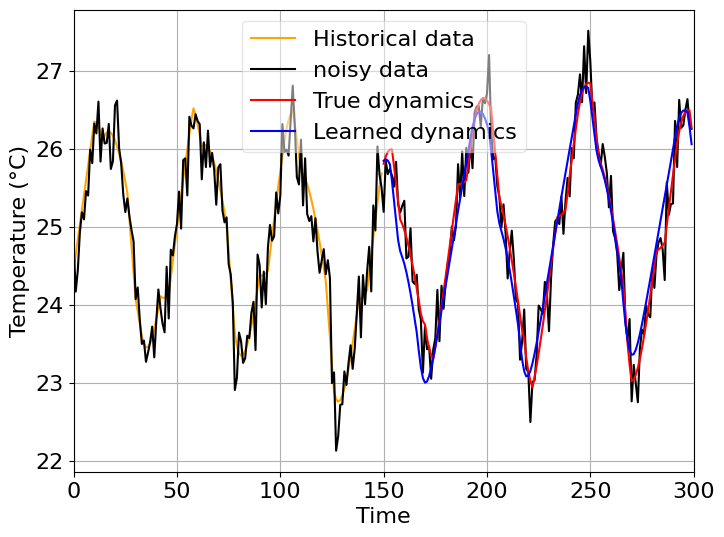

In [9]:
'''piece of code for testing of prediction'''
"""for controlled environment"""
init_t = (298.15, 20, 298.15, 298.15, 258.85,0)
#temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
'''sample true dynamics'''
'''piece of code for testing of prediction'''

'''initializing env.'''
env_t = environment(init_t)
session_length = 600
std_of_noise = 0.3
t_set=298.15
v_set=20
dt= 1
dv= 5
'''sample true dynamics'''

t, noisy_t, a, t_out =  env_t.controlled_session(session_length, std_of_noise,t_set,v_set,dt,dv)
t_test=t[:300]-273.13
t=t[300:]-273.13

noisy_t=noisy_t[300:] -273.13
t_out=t_out[300:]-273.13
'''historical data for extracting GRU hidden state'''
a_dec= np.zeros((0,1), dtype=int)
for i in range(len(a)):
  y=to_bin(a[i])
  a_dec=np.append(a_dec,np.array([y]).reshape((1,1)), axis=0)
a_dec=a_dec[300:]
t_hist = t[:150].reshape((1, -1))
a_hist = a_dec[:150].reshape((1, -1))
t_out_hist = t_out[:150].reshape((1, -1))
noisy_t_hist=noisy_t[:150].reshape((1, -1))
'''future data, we are going to predict'''
t_future = t[150:].reshape((1, -1))
a_future = a_dec[150:].reshape((1, -1))
t_out_future = t_out[150:].reshape((1, -1))
noisy_t_future=noisy_t[150:].reshape((1, -1))
initial_state = model.get_new_hidden_state(tf.convert_to_tensor(a_hist, dtype=tf.int32), tf.convert_to_tensor(t_hist, dtype=tf.float32), tf.convert_to_tensor(t_out_hist, dtype=tf.float32))
if len(initial_state.shape) == 1:
    initial_state = tf.expand_dims(initial_state, 0)
denoised_hist=model.t_denoising(tf.convert_to_tensor(noisy_t_hist, dtype=tf.float32),tf.convert_to_tensor(t_out_hist, dtype=tf.float32),tf.convert_to_tensor(a_hist, dtype=tf.int32))
outputs=[]
s=denoised_hist[0][-1]
for i in range(t_future.shape[1]):
  delta,initial_state = model.predict_next_state(tf.convert_to_tensor(a_future[0][i], dtype=tf.int32), s,tf.convert_to_tensor(t_out_future[0][i], dtype=tf.float32),initial_state)
  initial_state = tf.expand_dims(initial_state, 0)
  #initial_state=initial_state
  s=s+delta[0]
  #s=tf.squeeze(s),
  outputs.append(s),

# Prepare the true future dynamics (they are in t_future, shape (1, future_len))
true_future = t_future.flatten()

# --- Plotting the Results ---
fig, ax = plt.subplots(figsize=(8, 6))

# Plot historical data (used to extract hidden state)
ax.plot(range(150), t_hist.flatten(), 'orange', label='Historical data')

ax.plot(range(300), noisy_t.flatten(), 'black', label='noisy data')

# Plot true future dynamics. We start the x-axis at 150 to indicate that historical data covers 0-149.
ax.plot(range(150, 150 + len(true_future)), true_future, 'red', label='True dynamics')

# Plot predicted dynamics from the NN
ax.plot(range(150, 150 + len(outputs)), outputs, 'blue', label='Learned dynamics')

ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')
ax.set_xlim(0, 150 + len(true_future))
ax.legend(loc='best', framealpha=0.5)
ax.grid(True)
plt.show()

In [164]:
fig.savefig('./general_test_pred.pdf', format='pdf')


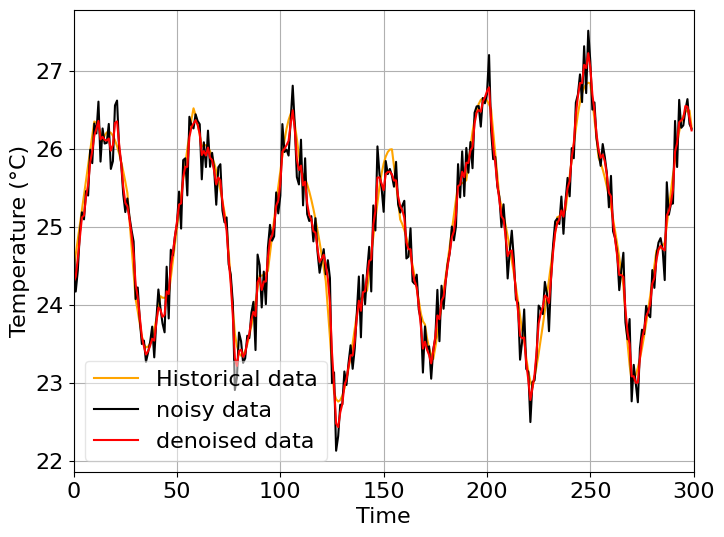

In [10]:
denoised=model.t_denoising(tf.convert_to_tensor(noisy_t.reshape((1, -1)), dtype=tf.float32),tf.convert_to_tensor(t_out.reshape((1, -1)), dtype=tf.float32),tf.convert_to_tensor(a_dec.reshape((1, -1)), dtype=tf.int32))
#denoised signa plotting 
fig, ax = plt.subplots(figsize=(8, 6))

# Plot historical data (used to extract hidden state)
ax.plot(range(300), t.flatten(), 'orange', label='Historical data')

ax.plot(range(300), noisy_t.flatten(), 'black', label='noisy data')

ax.plot(range(300), denoised[0], 'red', label='denoised data')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')
ax.set_xlim(0, 300 )
ax.legend(loc='best', framealpha=0.5)
ax.grid(True)
plt.show()

In [ ]:
fig.savefig('./general_test_denoised.pdf', format='pdf')


## testing a batch of predictions

In [53]:
test_results = test_batch(model,test_dataset, session_length=300, max_batches=1)
keys=list(test_results["metrics"])
for length in keys:
    print(f"Horizon {length}:")
    print(f"  RMSE: {test_results["metrics"][length]['rmse']:.4f}")
    print(f"  MSE: {test_results["metrics"][length]['mse']:.4f}")
    print(f"  MAE: {test_results["metrics"][length]['mae']:.4f}")
    print(f"  R²: {test_results["metrics"][length]['r2']:.4f}\n")


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

Horizon 30:
  RMSE: 0.1764
  MSE: 0.0421
  MAE: 0.1516
  R²: -53.6359

Horizon 60:
  RMSE: 0.1924
  MSE: 0.0484
  MAE: 0.1613
  R²: -0.0882

Horizon 90:
  RMSE: 0.2015
  MSE: 0.0524
  MAE: 0.1671
  R²: 0.6838

Horizon 120:
  RMSE: 0.2083
  MSE: 0.0565
  MAE: 0.1715
  R²: 0.7938

Horizon 150:
  RMSE: 0.2144
  MSE: 0.0607
  MAE: 0.1755
  R²: 0.8295



In [14]:
test_results["metrics"]

{30: {'mse': 0.052742615, 'mae': 0.1723376, 'r2': -9.418985},
 60: {'mse': 0.051150136, 'mae': 0.17355351, 'r2': -1.755328},
 90: {'mse': 0.054585315, 'mae': 0.1809572, 'r2': -0.6333424},
 120: {'mse': 0.056708016, 'mae': 0.18506092, 'r2': 0.18804139},
 150: {'mse': 0.05979868, 'mae': 0.18960717, 'r2': 0.4670485}}

## Save test data

In [24]:
export_temperatures(test_results,"./dataset/test results/temperature_results.npz")

Temperature data saved to ./dataset/test results/temperature_results.npz


## Restore test data

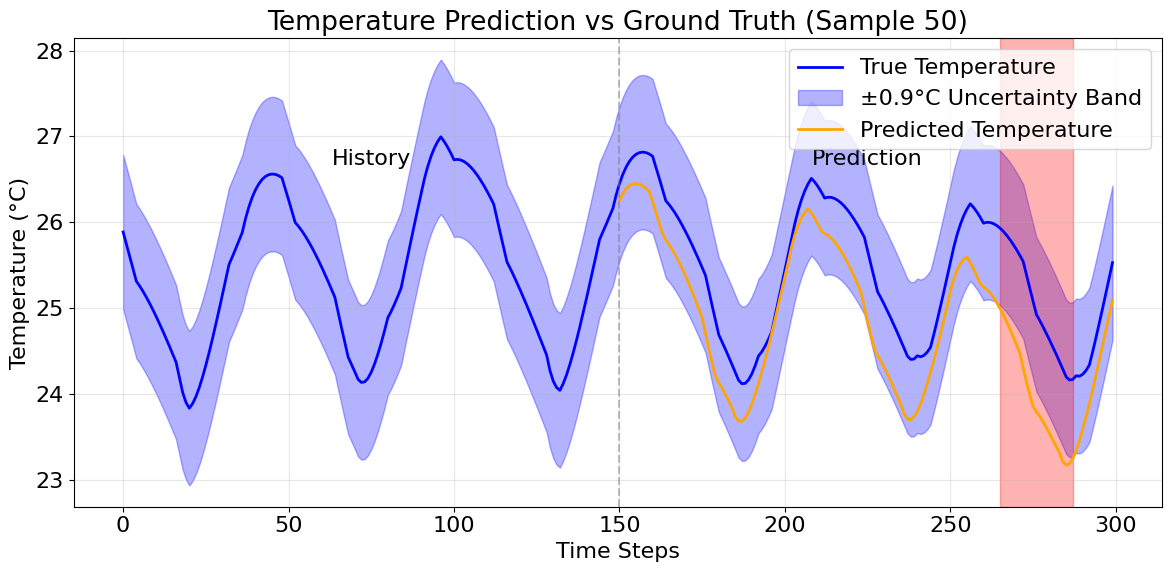

In [ ]:
imported_data = import_temperatures("./dataset/test results/temperature_results.npz")
t_init = imported_data["initial_temperatures"]
t_true = imported_data["true_temperatures"] 
t_pred = imported_data["predicted_temperatures"]
visualize_predictions(imported_data, element=50, n=15, uncertainty=0.9)

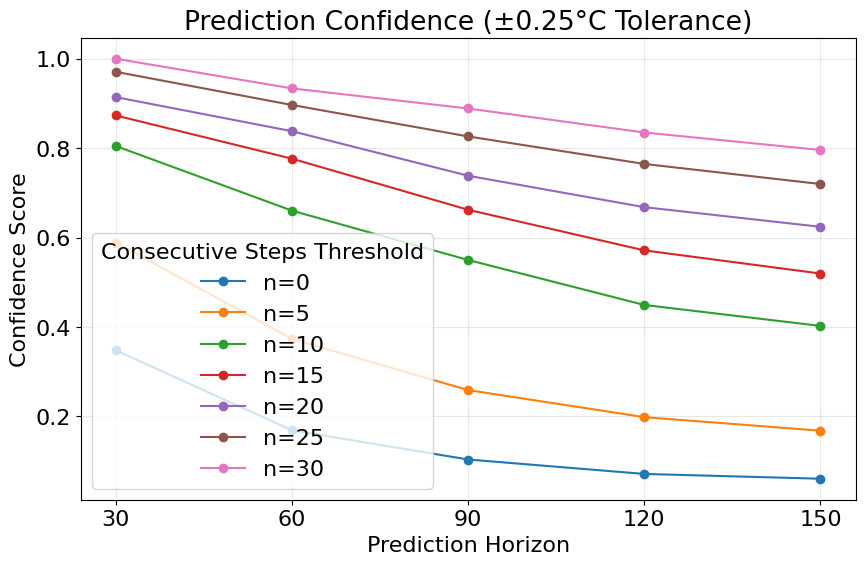

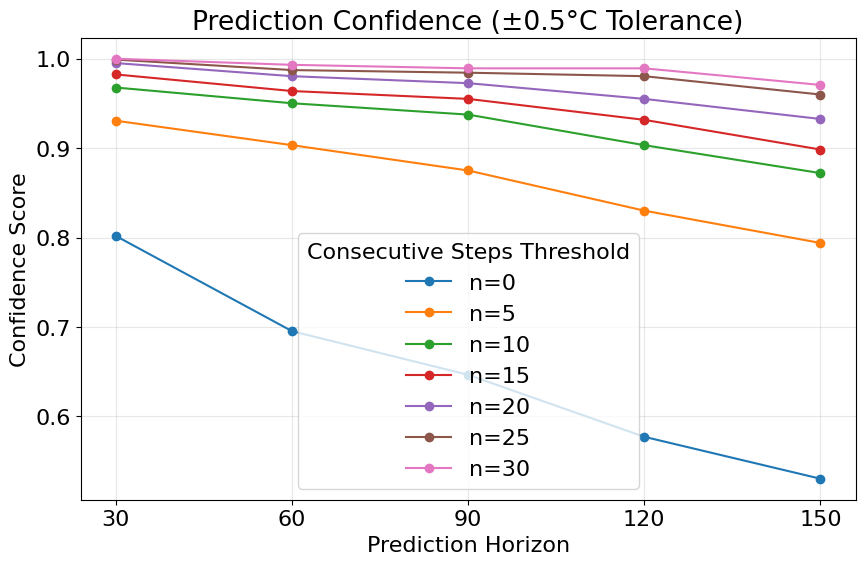

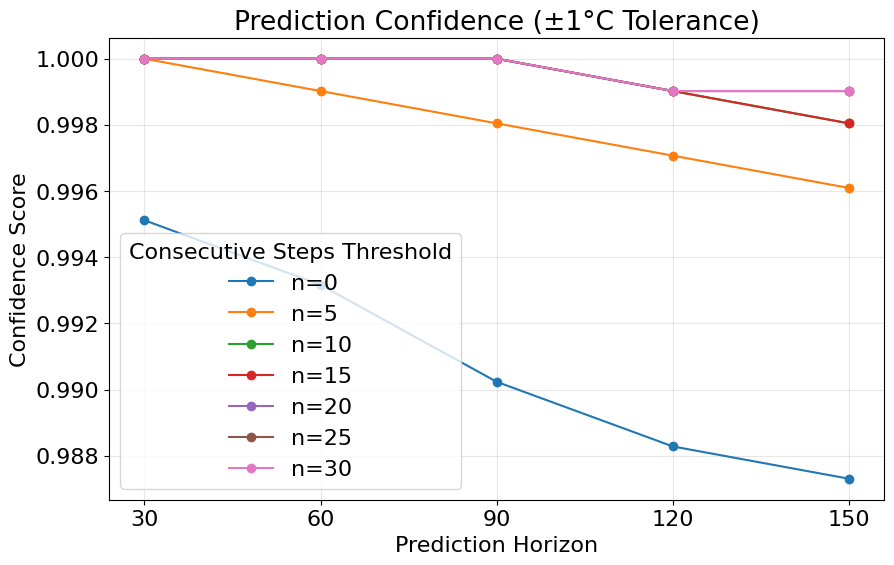


Summary Confidence Scores:
±0.25°C tolerance: 62.4% confidence
±0.5°C tolerance: 93.3% confidence
±1°C tolerance: 99.9% confidence


In [37]:
analysis_results = analyze_predictions(
        imported_data,
        uncertainty_ranges=[0.25, 0.5,1],
        n_values=[0, 5, 10, 15, 20, 25, 30],
        horizons=[30, 60, 90, 120, 150]
    )
    
    # Print summary
print("\nSummary Confidence Scores:")
for range_val, confidence in analysis_results['confidence'].items():
    print(f"±{range_val.split('_')[1]}°C tolerance: {confidence:.1%} confidence")

# test: DR


In [ ]:
t_t,index_pred,offset,offset_pred,bias = DR_test_batch( t_dr, a_dr, t_out_dr,dr, index, conf_lim, size=500)

index=index+(index==0)*300
index_pred=np.array(index_pred)
index_pred=index_pred+(index_pred==0)*300

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
np.mean(bias)

-1.824

In [ ]:
np.sqrt(np.var(bias))

2.303263771260253

In [ ]:
np.sqrt( mean_squared_error(index[:500].flatten(), index_pred))

2.944146735473624

In [ ]:
np.sqrt( mean_squared_error(index[:500].flatten(), index_pred))

2.944146735473624

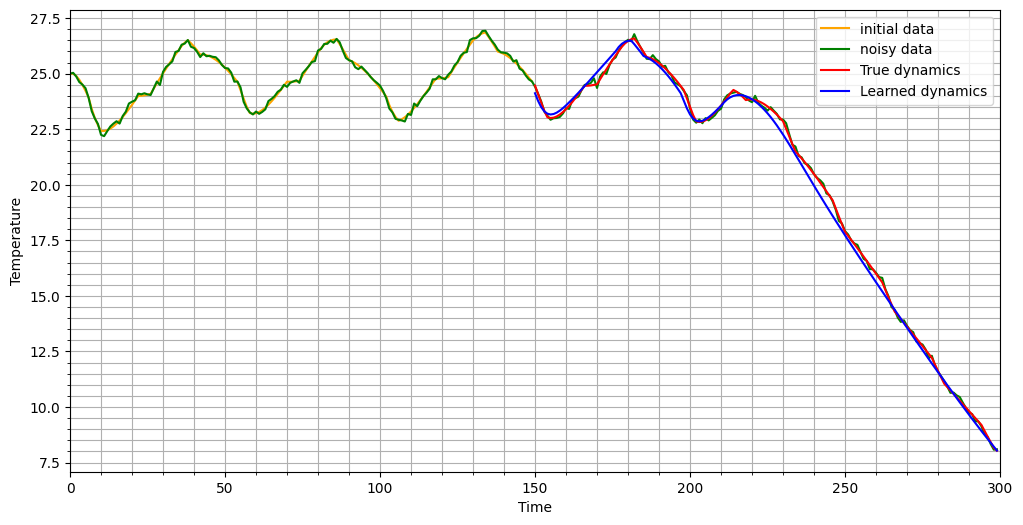

array([237.])

In [ ]:
#element to visualise
n=0
t=t_dr[+n]
noisy_t=noisy_t_dr[+n]
t_test=t_t[n]
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(6)
axs.plot(range(150), t[:150],'orange',label='initial data')
axs.plot(range(session_length), noisy_t,'green',label='noisy data')
axs.plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs.plot(range(150,session_length),t_test, 'blue',label="Learned dynamics")
axs.set_xlim(0, session_length)
axs.set_xlabel('Time')
axs.set_ylabel('Temperature')
axs.grid(True)
axs.grid(which = "minor")
axs.minorticks_on()
axs.legend()
plt.show()
index[n]

# Fault test  

## individual test

In [ ]:
n=5
t=t_f[+n]
noisy_t=noisy_t_f[+n]
a_dec=a_f[+n]
t_out=t_out_f[+n]
a_faulty=a_fault[+n]

t_hist = t[:150].reshape((1, -1))
a_hist = a_dec[:150].reshape((1, -1))
t_out_hist = t_out[:150].reshape((1, -1))

'''future data, we are going to predict'''
t_future = t[150:]
a_future = a_dec[150:]
t_out_future = t_out[150:]

'''current temperature of prediction'''
s = np.array(t[150])

'''extraction of hidden GRU state using historical data'''
in_rnn_state = extract_hidden_state( t_hist, a_hist, t_out_hist)
print(t_out[0])
'''prediction loop'''

'''initializing t collection'''
t_test = []
for i in range(session_length-150):

    '''update temperature (s) and hidden GRU state'''
    s, in_rnn_state = dyn_predict(s, a_future[i], t_out_future[i], in_rnn_state)


    '''adding to t collection'''
    t_test.append(s)

t_test = np.array(t_test).flatten()
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(8)
fig.set_figheight(6)
axs[0].plot(range(150), t[:150],'orange',label='Initial data')
axs[0].plot(range(session_length), noisy_t,'green',label='Noisy data')
axs[0].plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs[0].plot(range(150,session_length),t_test, 'blue',label="Learned dynamics")
axs[0].set_xlim(0, session_length)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend()
axs[1].plot(a_dec, 'r',label="HVAC commands")
axs[1].plot(a_faulty, 'b',label="HVAC real commands")
#axs[1].plot(ac_c[n0], 'g',label="ac on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()



plt.show()
fig.savefig('filename.eps', format='eps')

NameError: name 'extract_hidden_state' is not defined

## batch test

In [ ]:

t_t =np.array(test_batch_fault( t_c_test, a_c_test, t_out_c_test,size=500))
np.savez_compressed("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_pred.npz",t_t=t_t )

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
number_of_pieces = 1
session_length = 300

num=2
level="low"
dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise.npz"
data_f= np.load(dir)
data_test= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v7_test.npz")



t_out_f=np.vstack((data_f["t_out_f"],data_test["t_out_c"][:500]))
t_f=np.vstack((data_f["t_f"],data_test["t_c"][:500]))
noisy_t_f=np.vstack((data_f["noisy_t_f"],data_test["noisy_t_c"][:500]))
a_f=np.vstack((data_f["a_f"],data_test["a_c"][:500]))
a_fault=np.vstack((data_f['a_fault'],data_test["a_c"][:500]))

dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise_pred.npz"
data= np.load(dir)

data_t= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_pred.npz")
t_t=np.vstack((data["t_t"],data_t["t_t"]))

In [ ]:
t_out_f

array([[-14.95      , -14.95156737, -14.94457762, ..., -13.54437361,
        -13.54276269, -13.53697612],
       [-12.25      , -12.24646992, -12.24725246, ..., -10.99264071,
        -10.99475914, -10.99285677],
       [ -9.45      ,  -9.44957886,  -9.44163362, ...,  -8.05639774,
         -8.0534877 ,  -8.05058769],
       ...,
       [-11.01389771, -11.01027067, -11.01404372, ..., -10.90783524,
        -10.90637144, -10.9092483 ],
       [-10.91024445, -10.91619343, -10.92099204, ..., -12.48921929,
        -12.4958017 , -12.50109146],
       [-12.50467537, -12.5124511 , -12.51699857, ..., -14.36594134,
        -14.36075973, -14.35502808]])

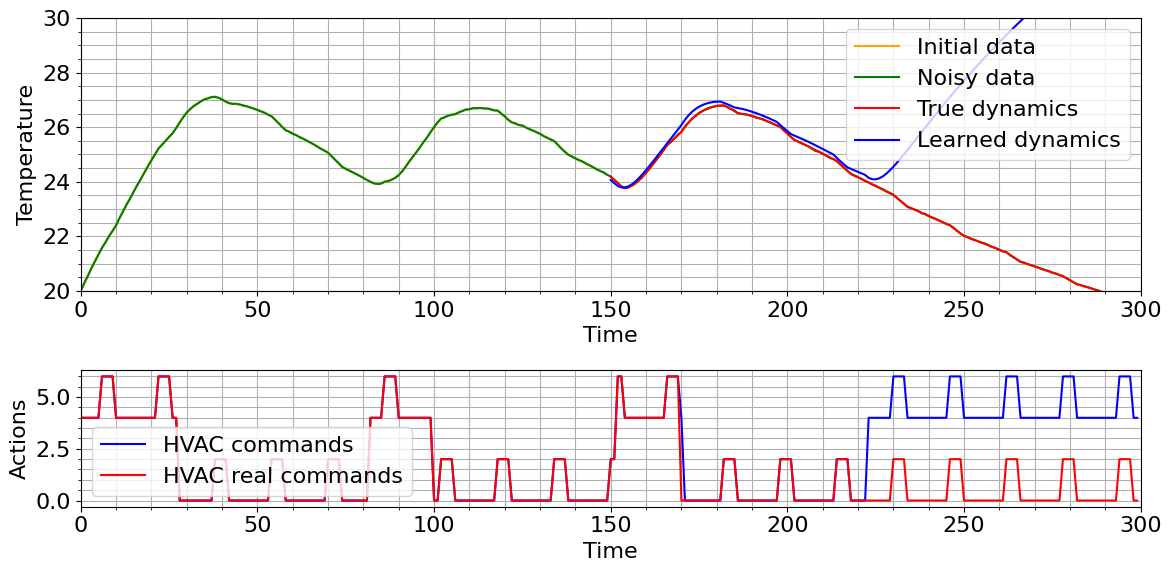

In [ ]:
n=10
t=t_f[+n]
t_pred=t_t[+n]
noisy_t=noisy_t_f[+n]
a_dec=a_f[+n]
t_out=t_out_f[+n]
a_faulty=a_fault[+n]
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(12)
fig.set_figheight(6)
axs[0].plot(range(150), t[:150],'orange',label='Initial data')
axs[0].plot(range(session_length), noisy_t,'green',label='Noisy data')
axs[0].plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs[0].plot(range(150,session_length),t_pred, 'blue',label="Learned dynamics")
#axs[0].axvspan(150+deviation[n],150+detection[n],color = 'b', label = 'Detection span '+str(detection[n]-deviation[n])+'min',alpha=0.2)
axs[0].set_xlim(0, session_length)
axs[0].set_ylim(20, 30)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend(loc=0)
axs[1].plot(a_dec, 'b',label="HVAC commands")
axs[1].plot(a_faulty, 'r',label="HVAC real commands")
#axs[1].plot(ac_c[n0], 'g',label="ac on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()

In [ ]:

def find_first_differences(matrix, t_hat):
    # Ensure both matrix and t_hat have the same number of rows
    if matrix.shape[0] != t_hat.shape[0]:
        raise ValueError("The number of vectors in the matrix and t_hat must be the same.")

    num_vectors = matrix.shape[0]
    results = []

    for i in range(num_vectors):
        vector1 = matrix[i]
        vector2 = t_hat[i]

        # Create a boolean array where elements are different
        differences = vector1 != vector2

        # Find the index of the first difference
        first_diff_index = np.argmax(differences)  # np.argmax returns the first maximum index (True)

        # Check if there was a difference found
        if differences[first_diff_index]:
            results.append(first_diff_index-150)
        else:
            results.append(150)  # No difference found

    return np.array(results)
import numpy as np

def first_out_of_tolerance_index(matrix1, matrix2, tolerance=1e-6):
    """
    Compare two matrices and return the index of the first value in each row
    where the difference between matrix1 and matrix2 exceeds the given tolerance.

    Args:
        matrix1 (np.ndarray): The first matrix.
        matrix2 (np.ndarray): The second matrix.
        tolerance (float): The tolerance within which values are considered "equal".

    Returns:
        list: List of column indices for the first out-of-tolerance value in each row.
              If no value in a row exceeds the tolerance, it returns -1 for that row.
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same dimensions.")

    # Calculate the absolute difference between the two matrices
    diff = np.abs(matrix1 - matrix2)

    # Find where the difference exceeds the tolerance
    mask = diff > tolerance

    # List to store the first out-of-tolerance index for each row
    first_out_of_tolerance = []

    # Iterate over rows to find the first column index where the tolerance is exceeded
    for row_mask in mask:
        col_idx = np.argmax(row_mask)  # Find the first 'True' value in the row mask
        if row_mask[col_idx]:  # Ensure that the column index corresponds to an out-of-tolerance value
            first_out_of_tolerance.append(col_idx)
        else:
            first_out_of_tolerance.append(-1)  # If no value in the row is out of tolerance

    return first_out_of_tolerance





In [ ]:
ref=[0.1,0.204,0.204*1.25,0.204*1.5,0.204*1.75,0.204*2,0.204*2.25,0.204*2.5,0.204*2.75,0.204*3,0.204*4]
#ref=[0,-0.1,-0.204,-0.204*1.25,-0.204*1.5,-0.204*1.75,-0.204*2,-0.204*2.25,-0.204*2.5,-0.204*2.75,-0.204*3,-0.204*4,-0.204*5,-0.204*6,-0.204*10,-0.204*15]
precision=[]
recall=[]
time=[]
for i in ref:
  detection,deviation=fault_response_time(t_f[:,150:], np.array(t_t), window_size=10, reference_value=i,rmse_threshold=ref[-1]*0.3 ,RMSE= True )
  deviation=find_first_differences(a_f,a_fault)
  gr_true=deviation!=150
  #gr_true[:500]=1
  #gr_true[:500]=gr_true[:500]*pred[:500]
  pred=detection!=150
  time_i=detection- deviation
  time_i=time_i[time_i>0]
  time.append(time_i.mean())
  precision.append(precision_score(gr_true,pred))
  recall.append( recall_score(gr_true,pred))


In [ ]:
time

[1.0,
 2.136904761904762,
 2.554913294797688,
 3.1853932584269664,
 3.5280898876404496,
 4.129213483146067,
 4.477528089887641,
 4.966292134831461,
 5.337078651685394,
 5.578651685393258,
 7.258426966292135]

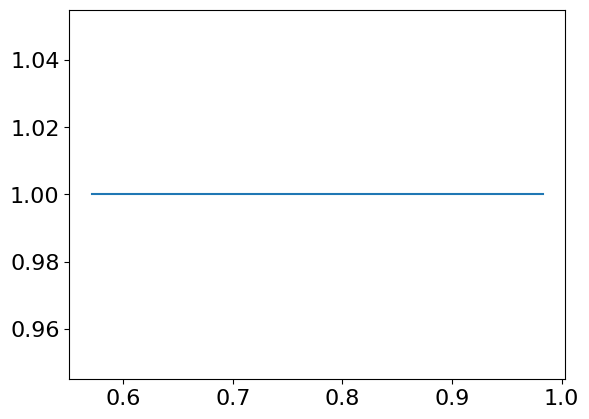

In [ ]:
plt.plot(precision,recall)


In [ ]:
precision

[0.19201725997842503,
 0.2176039119804401,
 0.24250681198910082,
 0.2692889561270802,
 0.29276315789473684,
 0.332089552238806,
 0.37872340425531914,
 0.4746666666666667,
 0.577922077922078,
 0.6926070038910506,
 0.9672131147540983]

In [ ]:
recall

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9943820224719101]

In [2]:
split_npz('../data_set_full_v7_test.npz', 'dataset/test/data_set_full_v7_test',max_size_mb=50)

NameError: name 'np' is not defined